In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import Toronto major crime indicators (MCI)
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 

- Other crimes:
    - homicide csv https://data.torontopolice.on.ca/datasets/TorontoPS::homicide-asr-rc-tbl-002/explore?location=43.721941%2C-79.371145%2C11.78&showTable=true
    - shootings csv https://data.torontopolice.on.ca/datasets/TorontoPS::shootings-and-firearm-discharges/explore?location=21.919150%2C-39.812750%2C4.69&showTable=true
    - Theft from motor vehicle https://data.torontopolice.on.ca/datasets/TorontoPS::theft-from-motor-vehicle/explore?location=22.246462%2C-39.965802%2C4.69&showTable=true
        - theft over 5,000 is already included in MCI as 'thefy over'
    - bicycle theft https://data.torontopolice.on.ca/datasets/TorontoPS::bicycle-thefts/explore?location=21.520237%2C-39.911850%2C4.53&showTable=true


In [4]:
mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')
mci_df.drop(columns = ['premises_type', 'x', 'y'], inplace = True)
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_15728\850645381.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')


occurrence_unique_id      occurrence_date  occurrence_year  \
0            GO-20141625305  2014-03-02 13:00:00             2014   
1            GO-20141272968  2013-12-24 13:00:00             2013   
2            GO-20141284361  2013-01-05 13:00:00             2013   
3            GO-20141292177  2013-12-31 13:00:00             2013   
4            GO-20141297201  2014-01-03 13:00:00             2014   
...                     ...                  ...              ...   
281687       GO-20211875584  2021-09-30 12:00:00             2021   
281688       GO-20211878198  2021-09-30 12:00:00             2021   
281689       GO-20211884903  2021-10-01 12:00:00             2021   
281690       GO-20211885958  2019-01-01 13:00:00             2019   
281691       GO-20211890330  2021-09-12 12:00:00             2021   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
0                 March               2                    61   
1              December              24                   358   
2               January               5                     5   
3              December              31                   365   
4               January               3                     3   
...                 ...             ...                   ...   
281687        September              30                   273   
281688        September              30                   273   
281689          October               1                   274   
281690          January               1                     1   
281691        September              12                   255   

       occurrence_dayofweek  occurrence_hour              MCI hood_id  \
0                Sunday                    8          Assault       1   
1                Tuesday                  22          Robbery       1   
2                Saturday                  4          Assault       1   
3                Tuesday                  21  Break and Enter       1   
4                Friday                   10  Break and Enter       1   
...                     ...              ...              ...     ...   
281687           Thursday                  4  Break and Enter     NSA   
281688           Thursday                 14          Robbery     NSA   
281689           Friday                   12          Assault     NSA   
281690           Tuesday                   0          Assault     NSA   
281691           Sunday                   18          Assault     NSA   

                 neighbourhood  longitude   latitude  
0       West Humber-Clairville -79.590332  43.734013  
1       West Humber-Clairville -79.600701  43.731834  
2       West Humber-Clairville -79.600794  43.686423  
3       West Humber-Clairville -79.603876  43.743642  
4       West Humber-Clairville -79.586443  43.697108  
...                        ...        ...        ...  
281687                     NSA   0.000000   0.000000  
281688                     NSA   0.000000   0.000000  
281689                     NSA -79.879105  43.497480  
281690                     NSA -79.766321  43.698093  
281691                     NSA   0.000000   0.000000  

[281692 rows x 13 columns]

In [339]:
mci_df.columns

Index(['occurrence_unique_id', 'occurrence_date', 'occurrence_year',
       'occurrence_month', 'occurrence_day', 'occurrence_dayofyear',
       'occurrence_dayofweek', 'occurrence_hour', 'MCI', 'hood_id',
       'neighbourhood', 'longitude', 'latitude'],
      dtype='object')

## Add data for shootings and homicide

In [341]:
# read and clean shootings data
shootings = pd.read_csv('../data/raw/Shootings.csv')
shootings.drop(columns=['time_range', 'death', 'injuries', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
shootings['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in shootings['neighbourhood']]
shootings['MCI'] = 'Shootings'

In [342]:
shootings.shape

(5328, 11)

In [343]:
# read and clean homicides data
homicide = pd.read_csv('../data/raw/Homicide.csv')
homicide.drop(columns=['homicide_type', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
homicide['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in homicide['neighbourhood']]
homicide['MCI'] = 'Homicide'

In [344]:
homicide.shape

(1252, 8)

In [345]:
# check columns are in the same order
pd.concat([mci_df.loc[0], shootings.loc[0], homicide.loc[0]], axis=1).T

occurrence_unique_id      occurrence_date occurrence_year occurrence_month  \
0       GO-20141625305  2014-03-02 13:00:00            2014            March   
0        GO-2004510813  2004-06-19 12:00:00            2004             June   
0       GO-20192106976  2019-10-31 12:00:00            2019              NaN   

  occurrence_day occurrence_dayofyear occurrence_dayofweek occurrence_hour  \
0              2                   61           Sunday                   8   
0            NaN                  NaN             Saturday            17.0   
0            NaN                  NaN                  NaN             NaN   

         MCI hood_id           neighbourhood  longitude   latitude  
0    Assault       1  West Humber-Clairville -79.590332  43.734013  
0  Shootings      23    Pelmo Park-Humberlea  -79.53608   43.71103  
0   Homicide      95                   Annex -79.404148  43.667464

In [346]:
mci_df = pd.concat([mci_df, shootings, homicide], axis=0).reset_index(drop=True)

## Missing data

In [347]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0].sort_values(ascending=False)

Columns with missing data


occurrence_day          6580
occurrence_dayofyear    6580
occurrence_month        1347
occurrence_dayofweek    1347
occurrence_hour         1253
occurrence_date            3
dtype: int64

In [348]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.loc[na_index]

occurrence_unique_id      occurrence_date  occurrence_year  \
1609         GO-20181572613  1995-01-01 13:00:00                0   
16184         GO-2019461576  1999-01-01 13:00:00                0   
16887         GO-2019461576  1999-01-01 13:00:00                0   
17480        GO-20151804633  1996-01-01 13:00:00                0   
19381        GO-20201870404  1980-01-01 13:00:00                0   
...                     ...                  ...              ...   
288267              1905589  2006-10-09 12:00:00             2006   
288268              1696286  2006-10-17 12:00:00             2006   
288269              1603174  2006-10-21 12:00:00             2006   
288270              1877732  2006-10-27 12:00:00             2006   
288271              1855834  2006-10-11 12:00:00             2006   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
1609                NaN             0.0                   0.0   
16184               NaN             0.0                   0.0   
16887               NaN             0.0                   0.0   
17480               NaN             0.0                   0.0   
19381               NaN             0.0                   0.0   
...                 ...             ...                   ...   
288267              NaN             NaN                   NaN   
288268              NaN             NaN                   NaN   
288269              NaN             NaN                   NaN   
288270              NaN             NaN                   NaN   
288271              NaN             NaN                   NaN   

       occurrence_dayofweek  occurrence_hour       MCI hood_id  \
1609                    NaN              9.0   Assault       1   
16184                   NaN              0.0   Assault       7   
16887                   NaN              0.0   Assault       7   
17480                   NaN              8.0   Assault       8   
19381                   NaN             12.0   Assault       9   
...                     ...              ...       ...     ...   
288267                  NaN              NaN  Homicide      43   
288268                  NaN              NaN  Homicide     119   
288269                  NaN              NaN  Homicide     135   
288270                  NaN              NaN  Homicide      16   
288271                  NaN              NaN  Homicide      71   

                           neighbourhood  longitude   latitude  
1609              West Humber-Clairville -79.614235  43.732190  
16184   Willowridge-Martingrove-Richview -79.564180  43.676839  
16887   Willowridge-Martingrove-Richview -79.564180  43.676839  
17480           Humber Heights-Westmount -79.527375  43.684156  
19381           Edenbridge-Humber Valley -79.512447  43.685515  
...                                  ...        ...        ...  
288267                  Victoria Village -79.304428  43.718907  
288268                  Wexford/Maryvale -79.300444  43.727942  
288269                       Morningside -79.194315  43.789276  
288270               Stonegate-Queensway -79.496230  43.627735  
288271   Cabbagetown-South St.James Town -79.364118  43.666093  

[6675 rows x 13 columns]

### load neighbourhood boundaries

In [349]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')

### fill na with occurence dates

In [350]:
# we can use occurencedate to fill these na values
mci_df['occurrence_date'] = pd.to_datetime(mci_df['occurrence_date'])

In [351]:
# let's see if we can imply the NA columns with the date column
# All okay except the hour column
# crimes should happen across the day but not only within 12:00 and 13:00
check_dates = pd.concat([
    mci_df['occurrence_date'].dt.day.describe(),
    mci_df['occurrence_date'].dt.dayofyear.describe(),
    mci_df['occurrence_date'].dt.month.describe(),
    mci_df['occurrence_date'].dt.weekday.describe(),
    mci_df['occurrence_date'].dt.hour.describe()
    ],
          axis=1)
check_dates.columns = ['dayofmonth', 'dayofyear', 'month', 'weekday', 'hour']
check_dates

dayofmonth      dayofyear          month        weekday  \
count  288269.000000  288269.000000  288269.000000  288269.000000   
mean       15.476919     186.088636       6.628965       3.052597   
std         8.915234     104.146855       3.404579       1.993407   
min         1.000000       1.000000       1.000000       0.000000   
25%         8.000000      98.000000       4.000000       1.000000   
50%        16.000000     188.000000       7.000000       3.000000   
75%        23.000000     275.000000      10.000000       5.000000   
max        31.000000     366.000000      12.000000       6.000000   

                hour  
count  288269.000000  
mean       12.335652  
std         0.472219  
min        12.000000  
25%        12.000000  
50%        12.000000  
75%        13.000000  
max        13.000000

In [352]:
# If we cannot imply missing hour from date, can we drop the rows with missing occurrence_hour instead?
# No
# Among those records with NA in occurrence_hour, there are 1,252 records linked to homicide
# that's almost 25% of all the homicide records
# therefore, we should not drop these rows
mci_df[mci_df['occurrence_hour'].isna()].groupby('MCI').size()

MCI
Homicide     1252
Shootings       1
dtype: int64

In [353]:
# instead, let's not use the column for occurrence_hour
mci_df.drop(columns=['occurrence_hour'], inplace=True)

In [354]:
def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrence_year'] = fix_na('occurrence_year',
                                  mci_df['occurrence_date'].dt.year.astype(float))
mci_df['occurrence_month'] = fix_na('occurrence_month',
                                   mci_df['occurrence_date'].dt.strftime("%B"))
mci_df['occurrence_day'] = fix_na('occurrence_day',
                                 mci_df['occurrence_date'].dt.day.astype(float))
mci_df['occurrence_dayofyear'] = fix_na('occurrence_dayofyear',
                                       mci_df['occurrence_date'].dt.dayofyear.astype(float))
mci_df['occurrence_dayofweek'] = fix_na('occurrence_dayofweek',
                                       mci_df['occurrence_date'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.loc[na_index]

occurrence_unique_id     occurrence_date  occurrence_year  \
1609         GO-20181572613 1995-01-01 13:00:00              0.0   
16184         GO-2019461576 1999-01-01 13:00:00              0.0   
16887         GO-2019461576 1999-01-01 13:00:00              0.0   
17480        GO-20151804633 1996-01-01 13:00:00              0.0   
19381        GO-20201870404 1980-01-01 13:00:00              0.0   
...                     ...                 ...              ...   
288267              1905589 2006-10-09 12:00:00           2006.0   
288268              1696286 2006-10-17 12:00:00           2006.0   
288269              1603174 2006-10-21 12:00:00           2006.0   
288270              1877732 2006-10-27 12:00:00           2006.0   
288271              1855834 2006-10-11 12:00:00           2006.0   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
1609            January             0.0                   0.0   
16184           January             0.0                   0.0   
16887           January             0.0                   0.0   
17480           January             0.0                   0.0   
19381           January             0.0                   0.0   
...                 ...             ...                   ...   
288267          October             9.0                 282.0   
288268          October            17.0                 290.0   
288269          October            21.0                 294.0   
288270          October            27.0                 300.0   
288271          October            11.0                 284.0   

       occurrence_dayofweek       MCI hood_id  \
1609                 Sunday   Assault       1   
16184                Friday   Assault       7   
16887                Friday   Assault       7   
17480                Monday   Assault       8   
19381               Tuesday   Assault       9   
...                     ...       ...     ...   
288267               Monday  Homicide      43   
288268              Tuesday  Homicide     119   
288269             Saturday  Homicide     135   
288270               Friday  Homicide      16   
288271            Wednesday  Homicide      71   

                           neighbourhood  longitude   latitude  
1609              West Humber-Clairville -79.614235  43.732190  
16184   Willowridge-Martingrove-Richview -79.564180  43.676839  
16887   Willowridge-Martingrove-Richview -79.564180  43.676839  
17480           Humber Heights-Westmount -79.527375  43.684156  
19381           Edenbridge-Humber Valley -79.512447  43.685515  
...                                  ...        ...        ...  
288267                  Victoria Village -79.304428  43.718907  
288268                  Wexford/Maryvale -79.300444  43.727942  
288269                       Morningside -79.194315  43.789276  
288270               Stonegate-Queensway -79.496230  43.627735  
288271   Cabbagetown-South St.James Town -79.364118  43.666093  

[6675 rows x 12 columns]

In [355]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


occurrence_date         3
occurrence_month        3
occurrence_dayofweek    3
dtype: int64

In [356]:
# let's drop these rows with missing occurrence_date
mci_df[mci_df.occurrence_date.isna() != 0]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
22978         GO-2015636294             NaT              0.0              NaN   
207153       GO-20143212768             NaT              0.0              NaN   
277185       GO-20142269218             NaT              0.0              NaN   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek      MCI  \
22978              0.0                   0.0                  NaN  Assault   
207153             0.0                   0.0                  NaN  Assault   
277185             0.0                   0.0                  NaN  Assault   

       hood_id               neighbourhood  longitude   latitude  
22978       14  Islington-City Centre West -79.530779  43.643038  
207153     107             Oakwood Village -79.446782  43.687272  
277185     NSA                         NSA   0.000000   0.000000

In [357]:
mci_df.dropna(subset=['occurrence_date'], inplace=True)

In [358]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Checking for date inconsistencies

In [359]:
# is the year, month, day etc. consistent with the date column?
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

92
0
92
92
281597


### inconsistency in year

In [360]:
# Inconsistency in year column
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, ['occurrence_date', 'occurrence_year']]

occurrence_date  occurrence_year
1609   1995-01-01 13:00:00              0.0
16184  1999-01-01 13:00:00              0.0
16887  1999-01-01 13:00:00              0.0
17480  1996-01-01 13:00:00              0.0
19381  1980-01-01 13:00:00              0.0
...                    ...              ...
279606 1972-01-01 13:00:00              0.0
279789 1984-01-01 13:00:00              0.0
279875 1989-09-11 12:00:00              0.0
280072 1979-12-25 13:00:00              0.0
281463 1998-01-01 13:00:00              0.0

[92 rows x 2 columns]

In [361]:
# all of the inconsistent records have year 0
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year]['occurrence_year'].unique()

array([0.])

In [362]:
# replace with correct year
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, 'occurrence_year'] = mci_df[mci_df.occurrence_date.dt.year != mci_df.occurrence_year].occurrence_date.dt.year

### inconsistency in day of month

In [363]:
# Inconsistency in day column
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, ['occurrence_date', 'occurrence_day']]

occurrence_date  occurrence_day
1609   1995-01-01 13:00:00             0.0
16184  1999-01-01 13:00:00             0.0
16887  1999-01-01 13:00:00             0.0
17480  1996-01-01 13:00:00             0.0
19381  1980-01-01 13:00:00             0.0
...                    ...             ...
279606 1972-01-01 13:00:00             0.0
279789 1984-01-01 13:00:00             0.0
279875 1989-09-11 12:00:00             0.0
280072 1979-12-25 13:00:00             0.0
281463 1998-01-01 13:00:00             0.0

[92 rows x 2 columns]

In [364]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day]['occurrence_day'].unique()

array([0.])

In [365]:
# replace with correct day
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, 'occurrence_day'] = mci_df[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day].occurrence_date.dt.day.astype(float)

### inconsistency in day of year

In [366]:
# Inconsistency in day of year column
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, ['occurrence_date', 'occurrence_dayofyear']]

occurrence_date  occurrence_dayofyear
1609   1995-01-01 13:00:00                   0.0
16184  1999-01-01 13:00:00                   0.0
16887  1999-01-01 13:00:00                   0.0
17480  1996-01-01 13:00:00                   0.0
19381  1980-01-01 13:00:00                   0.0
...                    ...                   ...
279606 1972-01-01 13:00:00                   0.0
279789 1984-01-01 13:00:00                   0.0
279875 1989-09-11 12:00:00                   0.0
280072 1979-12-25 13:00:00                   0.0
281463 1998-01-01 13:00:00                   0.0

[92 rows x 2 columns]

In [367]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear]['occurrence_dayofyear'].unique()

array([0.])

In [368]:
# replace with correct day of year
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, 'occurrence_dayofyear'] = mci_df[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear].occurrence_date.dt.dayofyear.astype(float)

### inconsistency in day of week

In [369]:
# Inconsistency in day of week column
# data looks correct but why is it showing inconsistency?
mci_df.loc[mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek, ['occurrence_date', 'occurrence_dayofweek']]

occurrence_date occurrence_dayofweek
0      2014-03-02 13:00:00           Sunday    
1      2013-12-24 13:00:00           Tuesday   
2      2013-01-05 13:00:00           Saturday  
3      2013-12-31 13:00:00           Tuesday   
4      2014-01-03 13:00:00           Friday    
...                    ...                  ...
281687 2021-09-30 12:00:00           Thursday  
281688 2021-09-30 12:00:00           Thursday  
281689 2021-10-01 12:00:00           Friday    
281690 2019-01-01 13:00:00           Tuesday   
281691 2021-09-12 12:00:00           Sunday    

[281597 rows x 2 columns]

In [370]:
# inconsistency due to white space in this column
mci_df.occurrence_dayofweek.unique()

array(['Sunday    ', 'Tuesday   ', 'Saturday  ', 'Friday    ',
       'Wednesday ', 'Monday    ', 'Thursday  ', 'Sunday', 'Friday',
       'Monday', 'Tuesday', 'Thursday', 'Saturday', 'Wednesday'],
      dtype=object)

In [371]:
mci_df.occurrence_dayofweek = [x.strip() for x in mci_df.occurrence_dayofweek]

In [372]:
# Now all columns are consistent with occurrence_date
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

0
0
0
0
0


### inconsistency in hood_ID and neighbourhood

In [373]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(mci_df.hood_id.unique()), len(mci_df.neighbourhood.unique()))

278 144


In [374]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [375]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')[:2].values

array([[129, 'Agincourt North', 1484],
       ['129', 'Agincourt North', 10]], dtype=object)

In [376]:
mci_df['hood_id'] = mci_df['hood_id'].astype(str)

In [377]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [378]:
# let's check with neighbourhood refers to hood_id = 3
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

In [380]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# duplicate in hood_id
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

hood_id           neighbourhood  counts
20     117              L'Amoreaux     112
21     117               LAmoreaux    2461
22     118  Tam O'Shanter-Sullivan      41
23     118   Tam OShanter-Sullivan    1808
92      54       O'Connor-Parkview      73
93      54        OConnor-Parkview    1804

In [381]:
# fix duplicate neighbourhood
mci_df.loc[(mci_df.hood_id == '117') & (mci_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
mci_df.loc[(mci_df.hood_id == '118') & (mci_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"
mci_df.loc[(mci_df.hood_id == '54') & (mci_df.neighbourhood == 'OConnor-Parkview'), 'neighbourhood'] = "O'Connor-Parkview"

In [382]:
# hood_id and neighbourhood are now 1-to-1
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

In [383]:
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

### inconsistency vs neighbourhood boundary

In [385]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], mci_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

neighbourhood_x hood_id neighbourhood_y
280026  Mimico (includes Humber Bay Shores)      17          Mimico

In [386]:
mci_df.loc[(mci_df.hood_id == '17') & (mci_df.neighbourhood == 'Mimico'), 'neighbourhood'] = "Mimico (includes Humber Bay Shores)"

In [387]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], mci_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

Empty DataFrame
Columns: [neighbourhood_x, hood_id, neighbourhood_y]
Index: []

## Fixing Dtypes

In [388]:
mci_df.dtypes

occurrence_unique_id            object
occurrence_date         datetime64[ns]
occurrence_year                float64
occurrence_month                object
occurrence_day                 float64
occurrence_dayofyear           float64
occurrence_dayofweek            object
MCI                             object
hood_id                         object
neighbourhood                   object
longitude                      float64
latitude                       float64
dtype: object

In [389]:
# 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear' should not be of type float
mci_df.columns[mci_df.dtypes == float]

Index(['occurrence_year', 'occurrence_day', 'occurrence_dayofyear',
       'longitude', 'latitude'],
      dtype='object')

In [390]:
for x in ['occurrence_year', 'occurrence_day', 'occurrence_dayofyear']:
    mci_df[x] = mci_df[x].astype(int)

## Imputing missing longitude and latitude

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>]], dtype=object)

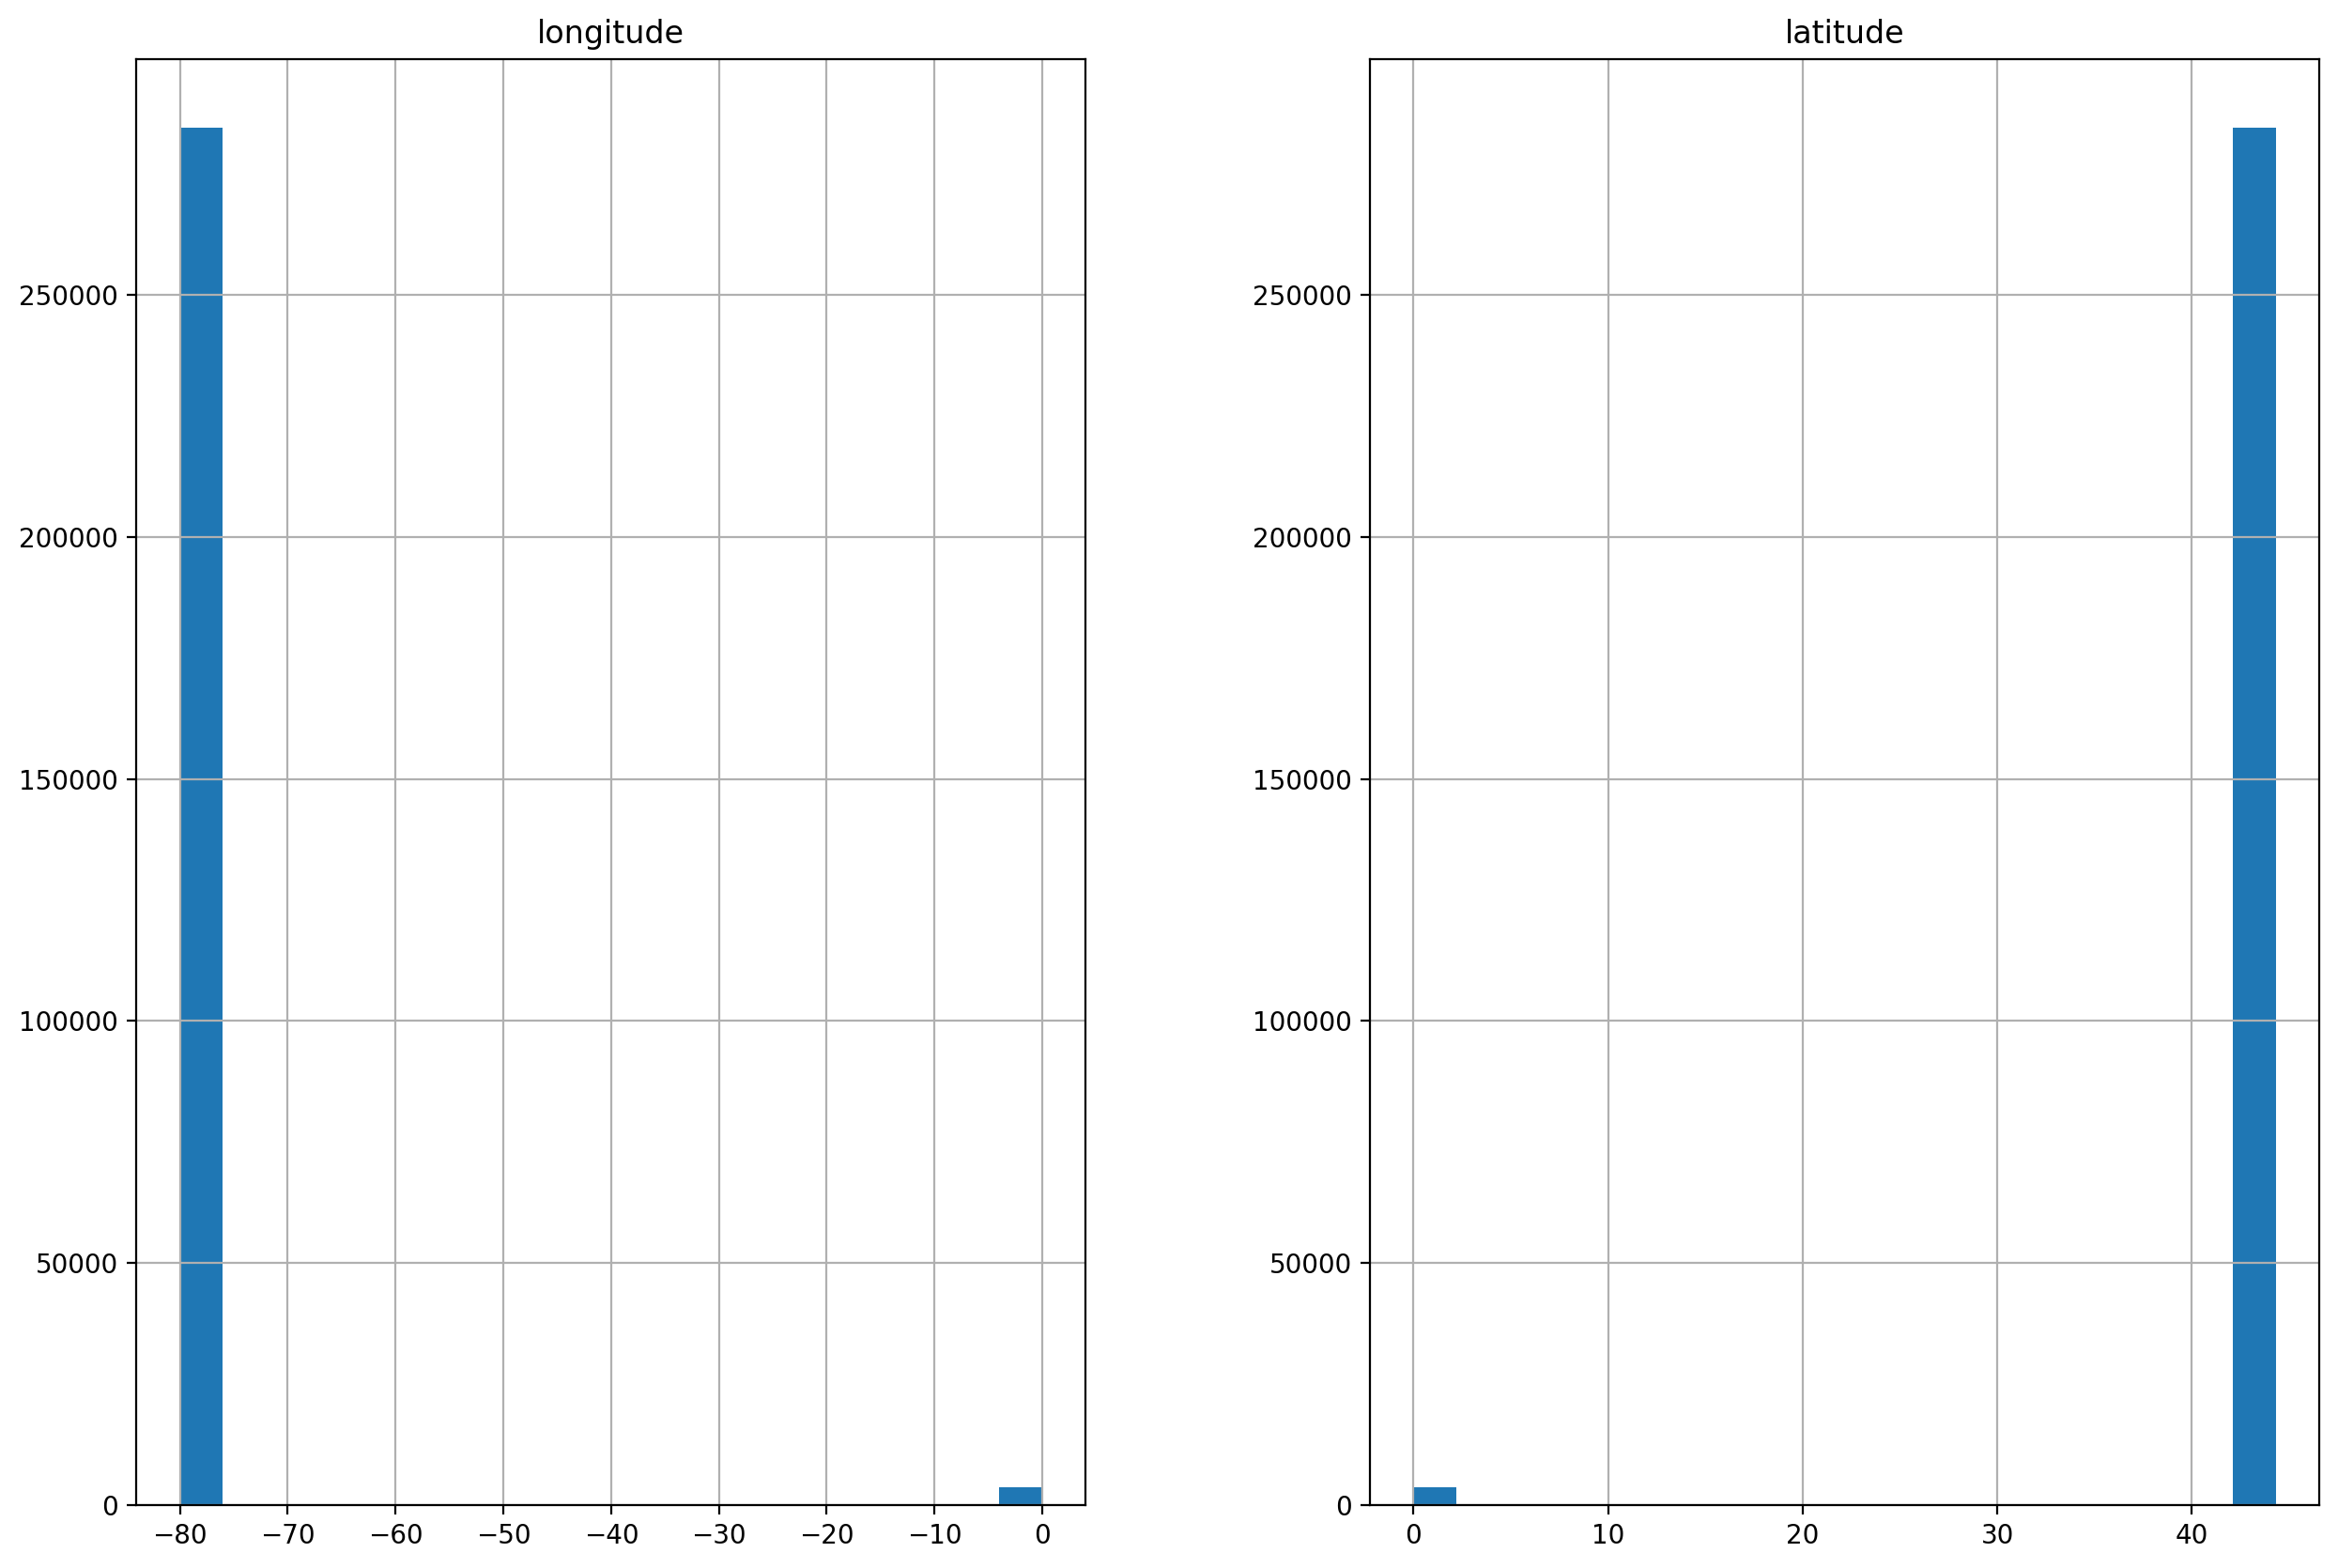

In [391]:
# missing longitude and latitude values are stored as 0
mci_df[['longitude','latitude']].hist(bins=20)

In [392]:
mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0), ["neighbourhood", "hood_id"]].value_counts()

neighbourhood                        hood_id
NSA                                  NSA        3396
Wexford/Maryvale                     119          57
Yorkdale-Glen Park                   31           38
West Hill                            136          25
Bay Street Corridor                  76           17
York University Heights              27           15
Bendale                              127          15
Glenfield-Jane Heights               25           13
Kennedy Park                         124           7
Mimico (includes Humber Bay Shores)  17            6
Tam O'Shanter-Sullivan               118           5
Highland Creek                       134           5
Victoria Village                     43            5
Downsview-Roding-CFB                 26            4
Pelmo Park-Humberlea                 23            4
Newtonbrook East                     50            4
Clairlea-Birchmount                  120           4
Bathurst Manor                       34            4
H

### Estimate with given neighbourhood

In [393]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['longitude'] == 0) & (mci_df['latitude'] == 0) & (mci_df['neighbourhood'] == "NSA"))].reset_index(drop=True)

In [394]:
missing_location = mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0)].index
mci_df.loc[missing_location]

occurrence_unique_id     occurrence_date  occurrence_year  \
2720         GO-20181222720 2018-07-05 12:00:00             2018   
9125         GO-20192152732 2019-11-07 13:00:00             2019   
9500         GO-20171616525 2017-09-06 12:00:00             2017   
10361        GO-20141665589 2014-03-08 13:00:00             2014   
10362        GO-20141665589 2014-03-08 13:00:00             2014   
...                     ...                 ...              ...   
265918        GO-2019279847 2019-02-13 13:00:00             2019   
266580       GO-20201116842 2020-06-17 12:00:00             2020   
271074       GO-20191794829 2019-09-18 12:00:00             2019   
273746       GO-20181409483 2018-07-31 12:00:00             2018   
274440       GO-20191808146 2019-09-20 12:00:00             2019   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
2720               July               5                   186   
9125           November               7                   311   
9500          September               6                   249   
10361             March               8                    67   
10362             March               8                    67   
...                 ...             ...                   ...   
265918         February              13                    44   
266580             June              17                   169   
271074        September              18                   261   
273746             July              31                   212   
274440        September              20                   263   

       occurrence_dayofweek      MCI hood_id  \
2720               Thursday  Assault       1   
9125               Thursday  Assault       2   
9500              Wednesday  Assault       2   
10361              Saturday  Assault       3   
10362              Saturday  Assault       3   
...                     ...      ...     ...   
265918            Wednesday  Assault     136   
266580            Wednesday  Assault     136   
271074            Wednesday  Assault     137   
273746              Tuesday  Assault     138   
274440               Friday  Robbery     138   

                            neighbourhood  longitude  latitude  
2720               West Humber-Clairville        0.0       0.0  
9125    Mount Olive-Silverstone-Jamestown        0.0       0.0  
9500    Mount Olive-Silverstone-Jamestown        0.0       0.0  
10361        Thistletown-Beaumond Heights        0.0       0.0  
10362        Thistletown-Beaumond Heights        0.0       0.0  
...                                   ...        ...       ...  
265918                          West Hill        0.0       0.0  
266580                          West Hill        0.0       0.0  
271074                             Woburn        0.0       0.0  
273746                      Eglinton East        0.0       0.0  
274440                      Eglinton East        0.0       0.0  

[278 rows x 12 columns]

In [395]:
missing_count = mci_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

hood_id  count
0      119     57
1       31     38
2      136     25
3       76     17
4       27     15
5      127     15
6       25     13
7      124      7
8       17      6
9      134      5
10      43      5
11     118      5
12      34      4
13     120      4
14      50      4
15      26      4
16      23      4
17      24      3
18      21      3
19     128      3
20      55      2
21     121      2
22     117      2
23      95      2
24      70      2
25       1      2
26     138      2
27      51      2
28       3      2
29      48      2
30      46      2
31       2      2
32      19      1
33     137      1
34       5      1
35       7      1
36       8      1
37     123      1
38      14      1
39      49      1
40      32      1
41      36      1
42     102      1
43      98      1
44      97      1
45      82      1
46      77      1
47      73      1
48      41      1

### Generate random locations given a neighbourhood

In [396]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.bounds.values.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighbourhood


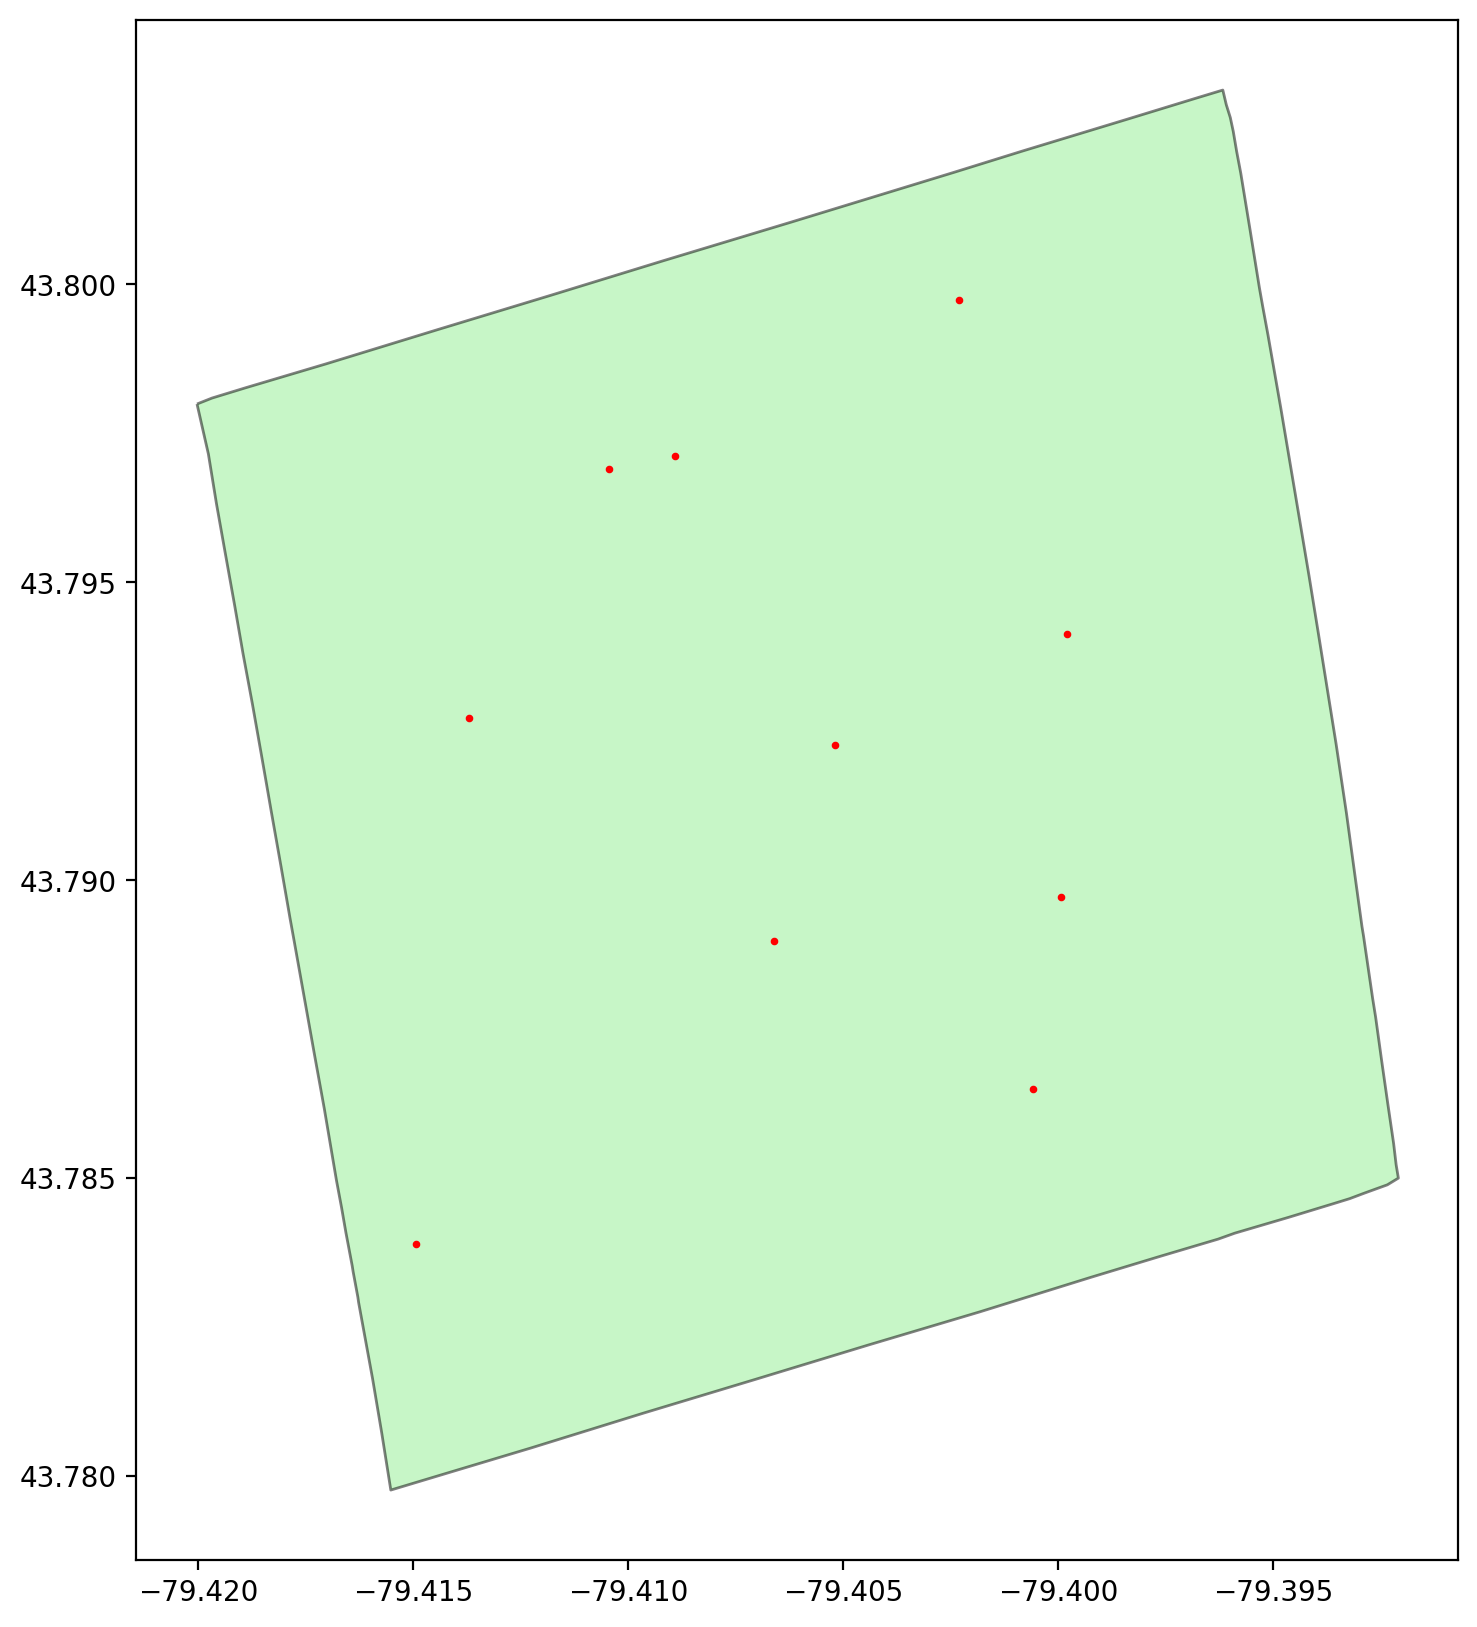

In [397]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighbourhood
# no red dots should be outside the neighbourhood
ax = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood)].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [398]:
np.random.seed(123)
missing_count[['longitude', 'latitude']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

78 points generated but only include the 57 points within the neighbourhood
68 points generated but only include the 38 points within the neighbourhood
36 points generated but only include the 25 points within the neighbourhood
33 points generated but only include the 17 points within the neighbourhood
21 points generated but only include the 15 points within the neighbourhood
25 points generated but only include the 15 points within the neighbourhood
17 points generated but only include the 13 points within the neighbourhood
11 points generated but only include the 7 points within the neighbourhood
12 points generated but only include the 6 points within the neighbourhood
11 points generated but only include the 5 points within the neighbourhood
6 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
20 points generated but only include the 4 points within the neighbourhood
11 points generated 

In [399]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['longitude'].apply(lambda x: len(x))
missing_count

hood_id  count                                          longitude  \
0      119     57  [-79.2905474645034, -79.31024017310659, -79.28...   
1       31     38  [-79.4499056676438, -79.44883602114473, -79.45...   
2      136     25  [-79.18296212725186, -79.19663494516615, -79.1...   
3       76     17  [-79.38932911965928, -79.38449277038399, -79.3...   
4       27     15  [-79.50615108937204, -79.49818915895317, -79.4...   
5      127     15  [-79.26173575446603, -79.25071559017856, -79.2...   
6       25     13  [-79.52250802047399, -79.52515598534787, -79.5...   
7      124      7  [-79.2698888813491, -79.26348211881192, -79.25...   
8       17      6  [-79.48539949794953, -79.48636352360387, -79.5...   
9      134      5  [-79.17564550360225, -79.17614106413124, -79.1...   
10      43      5  [-79.31025363653924, -79.32092412537807, -79.3...   
11     118      5  [-79.29767732901965, -79.32232303122326, -79.2...   
12      34      4  [-79.4376689202518, -79.45695716971886, -79.45...   
13     120      4  [-79.28623756894703, -79.2795796634251, -79.27...   
14      50      4  [-79.39493558317892, -79.41882559960113, -79.4...   
15      26      4  [-79.47948435013984, -79.5100491869697, -79.49...   
16      23      4  [-79.5156199521706, -79.53497930938873, -79.53...   
17      24      3  [-79.52511446132782, -79.53143572959488, -79.5...   
18      21      3  [-79.56162486398678, -79.54388610081277, -79.5...   
19     128      3  [-79.24497282305501, -79.27670961768489, -79.2...   
20      55      2           [-79.35492647398506, -79.36004095819271]   
21     121      2           [-79.28515332114694, -79.27488503131676]   
22     117      2           [-79.32023462103517, -79.30990984533267]   
23      95      2           [-79.40809989702096, -79.40823667512875]   
24      70      2            [-79.33840726892258, -79.3562558290554]   
25       1      2            [-79.56722041726331, -79.6159356893364]   
26     138      2           [-79.24761088438852, -79.24218161733148]   
27      51      2           [-79.40899270948213, -79.39413071778552]   
28       3      2            [-79.56110107509437, -79.5467950100769]   
29      48      2            [-79.36386339499745, -79.3575184926576]   
30      46      2           [-79.32756124025617, -79.33160612008179]   
31       2      2           [-79.57991461666839, -79.58058142980832]   
32      19      1                               [-79.52366994551902]   
33     137      1                               [-79.24966380790087]   
34       5      1                                [-79.5504636451516]   
35       7      1                               [-79.54595754868012]   
36       8      1                               [-79.52546513306828]   
37     123      1                               [-79.25014629062906]   
38      14      1                               [-79.53753277169096]   
39      49      1                               [-79.37075218906185]   
40      32      1                               [-79.43933484651906]   
41      36      1                               [-79.42602780598496]   
42     102      1                               [-79.43198861908215]   
43      98      1                               [-79.39270730964536]   
44      97      1                               [-79.39267579240193]   
45      82      1                               [-79.42030250369282]   
46      77      1                               [-79.36638100003044]   
47      73      1                                [-79.3706217679459]   
48      41      1                               [-79.36676109201835]   

                                             latitude  len  
0   [43.73845162529402, 43.75118356521948, 43.7450...   57  
1   [43.72667387681818, 43.71306448845523, 43.7229...   38  
2   [43.77929081550005, 43.77017760574194, 43.7777...   25  
3   [43.66365378334848, 43.65329698972922, 43.6624...   17  
4   [43.754671908621695, 43.75079559393119, 43.762...   15  
5   [43.75266128515352, 43.743225602

In [400]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (mci_df['hood_id'] == str(i)) & ((mci_df['longitude'] == 0) | (mci_df['latitude'] == 0))
    # mci_df.loc[index, ['longitude', 'latitude']] = 
    mci_df.loc[index, ['longitude', 'latitude']] = pd.DataFrame([np.where(mci_df.loc[index, 'longitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['longitude'].values[0],
                                                                  mci_df.loc[index, 'longitude']),
                                                         np.where(mci_df.loc[index, 'latitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['latitude'].values[0],
                                                                  mci_df.loc[index, 'latitude'])]).T.values

In [401]:
# check missing long and lat values are now imputed
mci_df.loc[missing_location]

occurrence_unique_id     occurrence_date  occurrence_year  \
2720         GO-20181222720 2018-07-05 12:00:00             2018   
9125         GO-20192152732 2019-11-07 13:00:00             2019   
9500         GO-20171616525 2017-09-06 12:00:00             2017   
10361        GO-20141665589 2014-03-08 13:00:00             2014   
10362        GO-20141665589 2014-03-08 13:00:00             2014   
...                     ...                 ...              ...   
265918        GO-2019279847 2019-02-13 13:00:00             2019   
266580       GO-20201116842 2020-06-17 12:00:00             2020   
271074       GO-20191794829 2019-09-18 12:00:00             2019   
273746       GO-20181409483 2018-07-31 12:00:00             2018   
274440       GO-20191808146 2019-09-20 12:00:00             2019   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
2720               July               5                   186   
9125           November               7                   311   
9500          September               6                   249   
10361             March               8                    67   
10362             March               8                    67   
...                 ...             ...                   ...   
265918         February              13                    44   
266580             June              17                   169   
271074        September              18                   261   
273746             July              31                   212   
274440        September              20                   263   

       occurrence_dayofweek      MCI hood_id  \
2720               Thursday  Assault       1   
9125               Thursday  Assault       2   
9500              Wednesday  Assault       2   
10361              Saturday  Assault       3   
10362              Saturday  Assault       3   
...                     ...      ...     ...   
265918            Wednesday  Assault     136   
266580            Wednesday  Assault     136   
271074            Wednesday  Assault     137   
273746              Tuesday  Assault     138   
274440               Friday  Robbery     138   

                            neighbourhood  longitude   latitude  
2720               West Humber-Clairville -79.567220  43.701489  
9125    Mount Olive-Silverstone-Jamestown -79.579915  43.761974  
9500    Mount Olive-Silverstone-Jamestown -79.580581  43.731631  
10361        Thistletown-Beaumond Heights -79.561101  43.738548  
10362        Thistletown-Beaumond Heights -79.546795  43.740109  
...                                   ...        ...        ...  
265918                          West Hill -79.170669  43.759099  
266580                          West Hill -79.164050  43.759760  
271074                             Woburn -79.249664  43.769874  
273746                      Eglinton East -79.247611  43.738554  
274440                      Eglinton East -79.242182  43.736294  

[278 rows x 12 columns]

### Add geometry for points

In [402]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [403]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

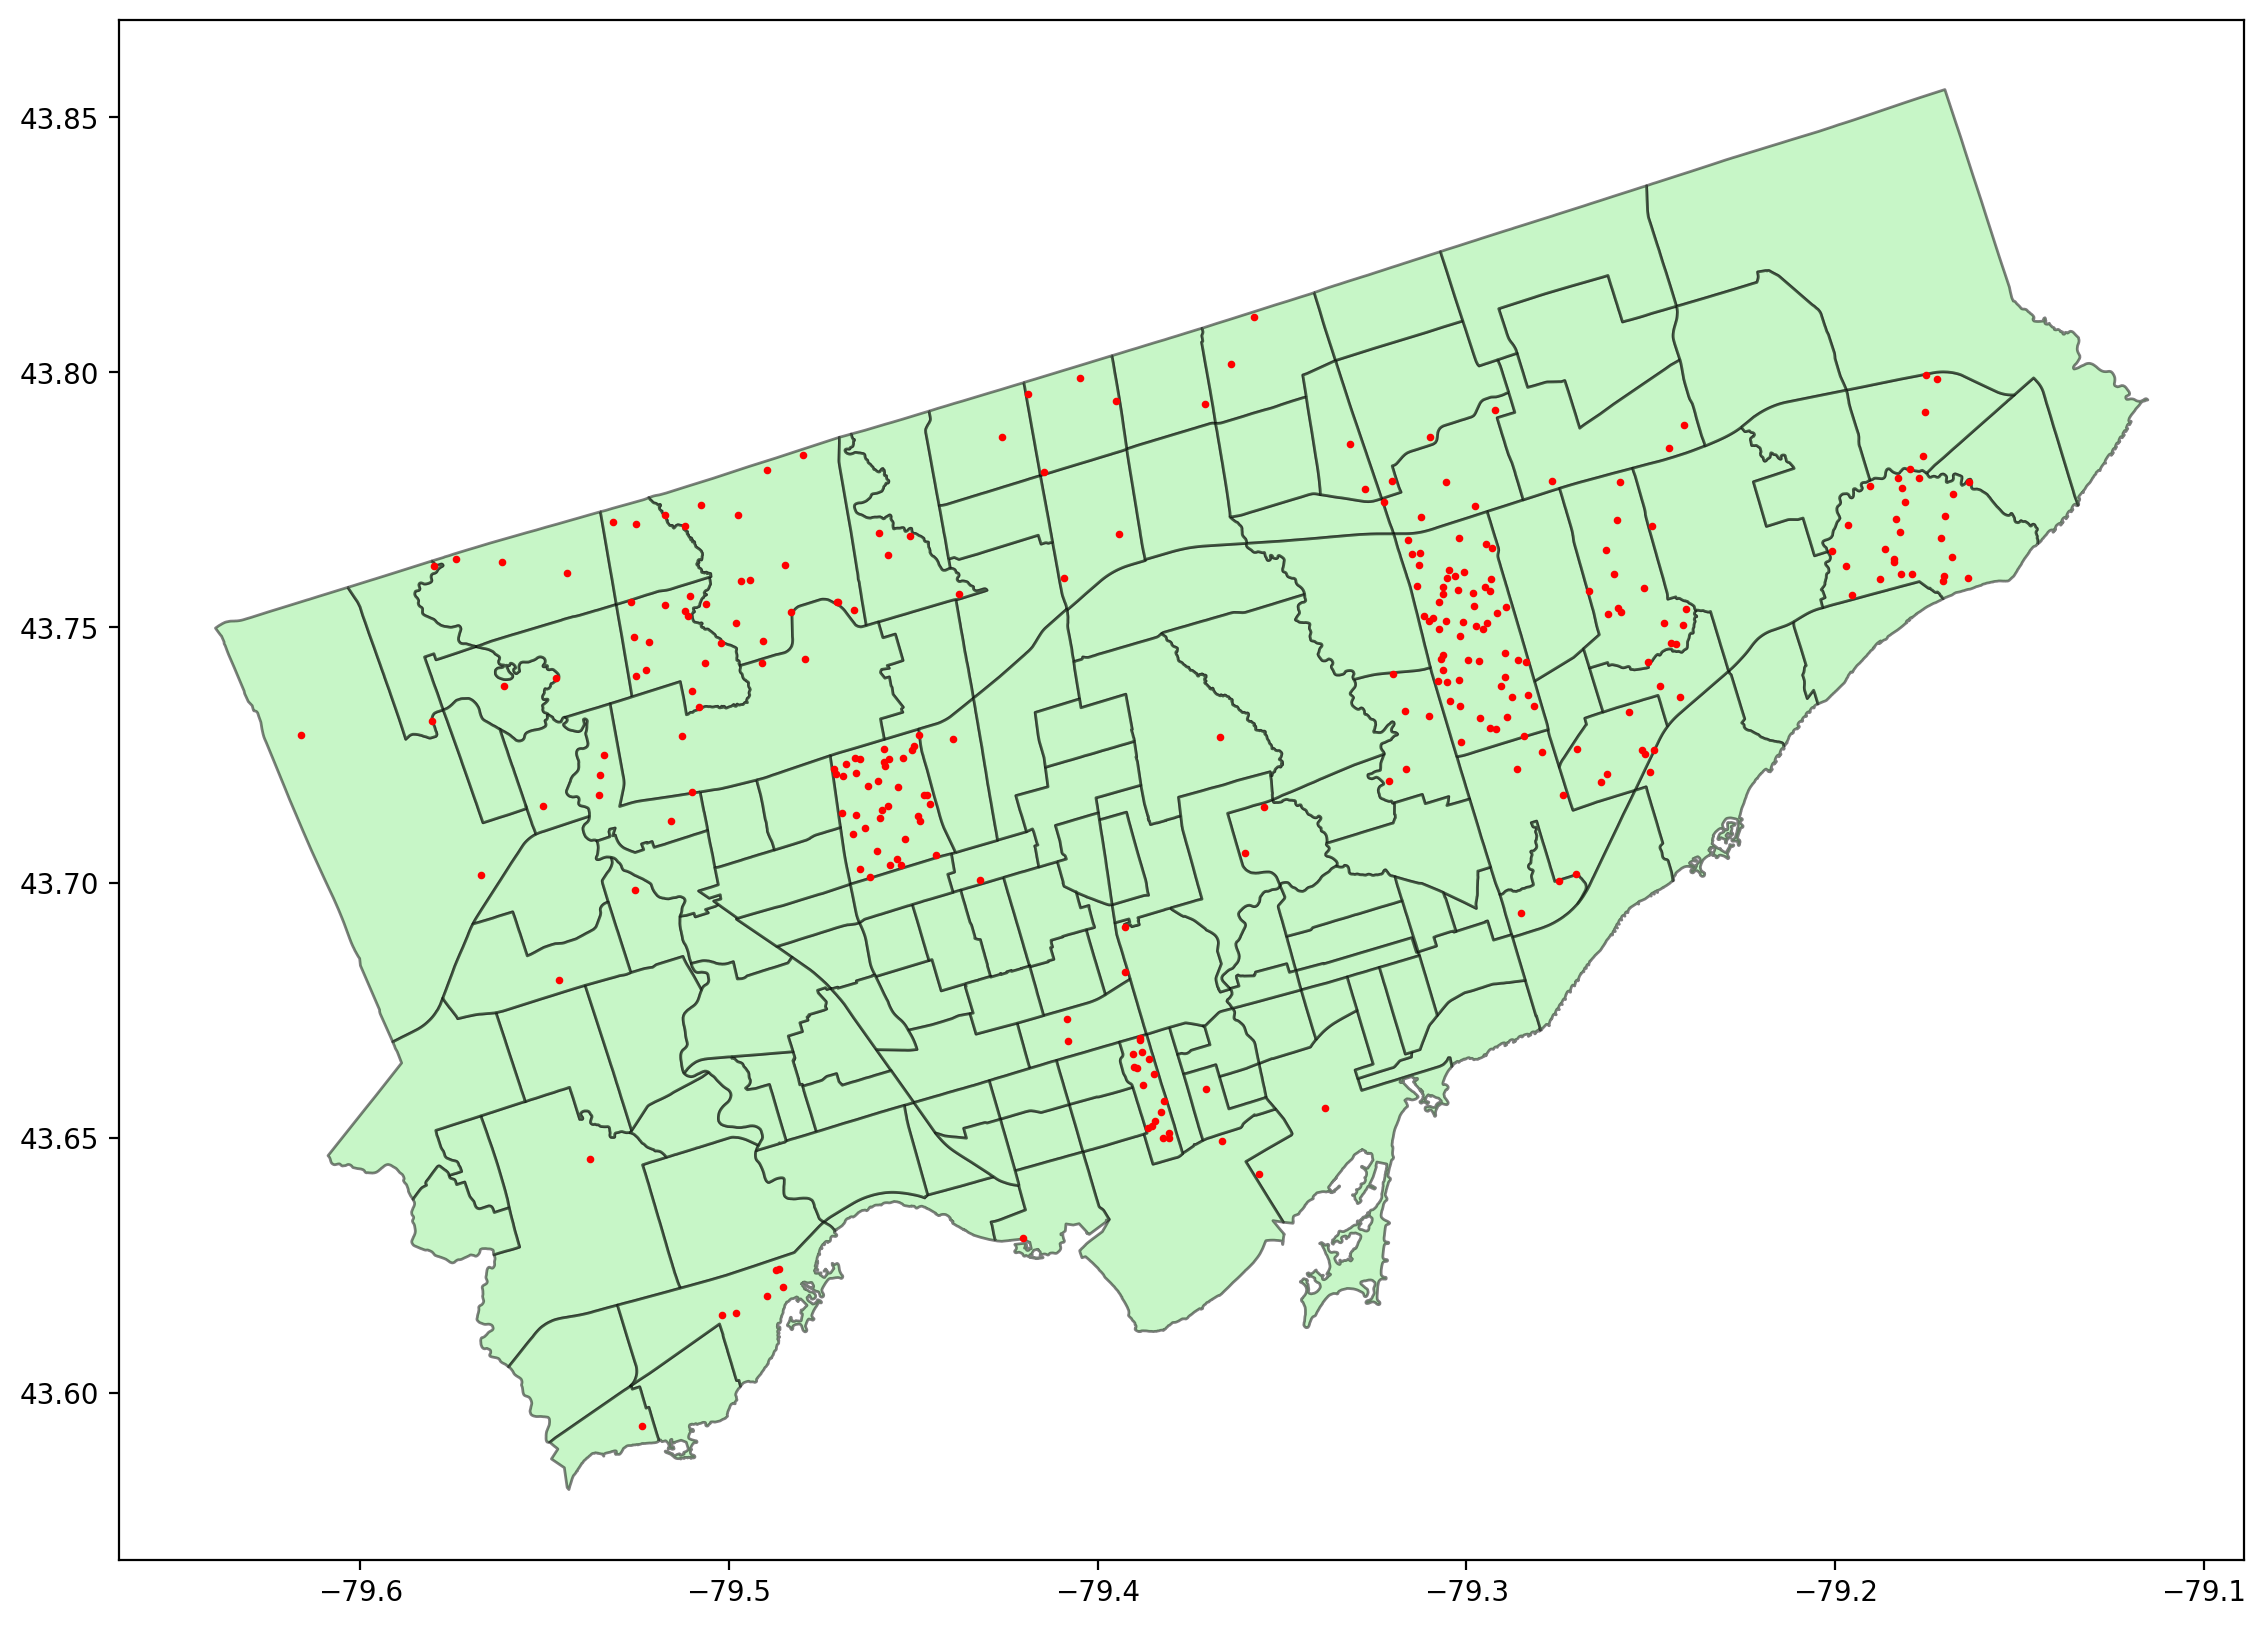

In [404]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

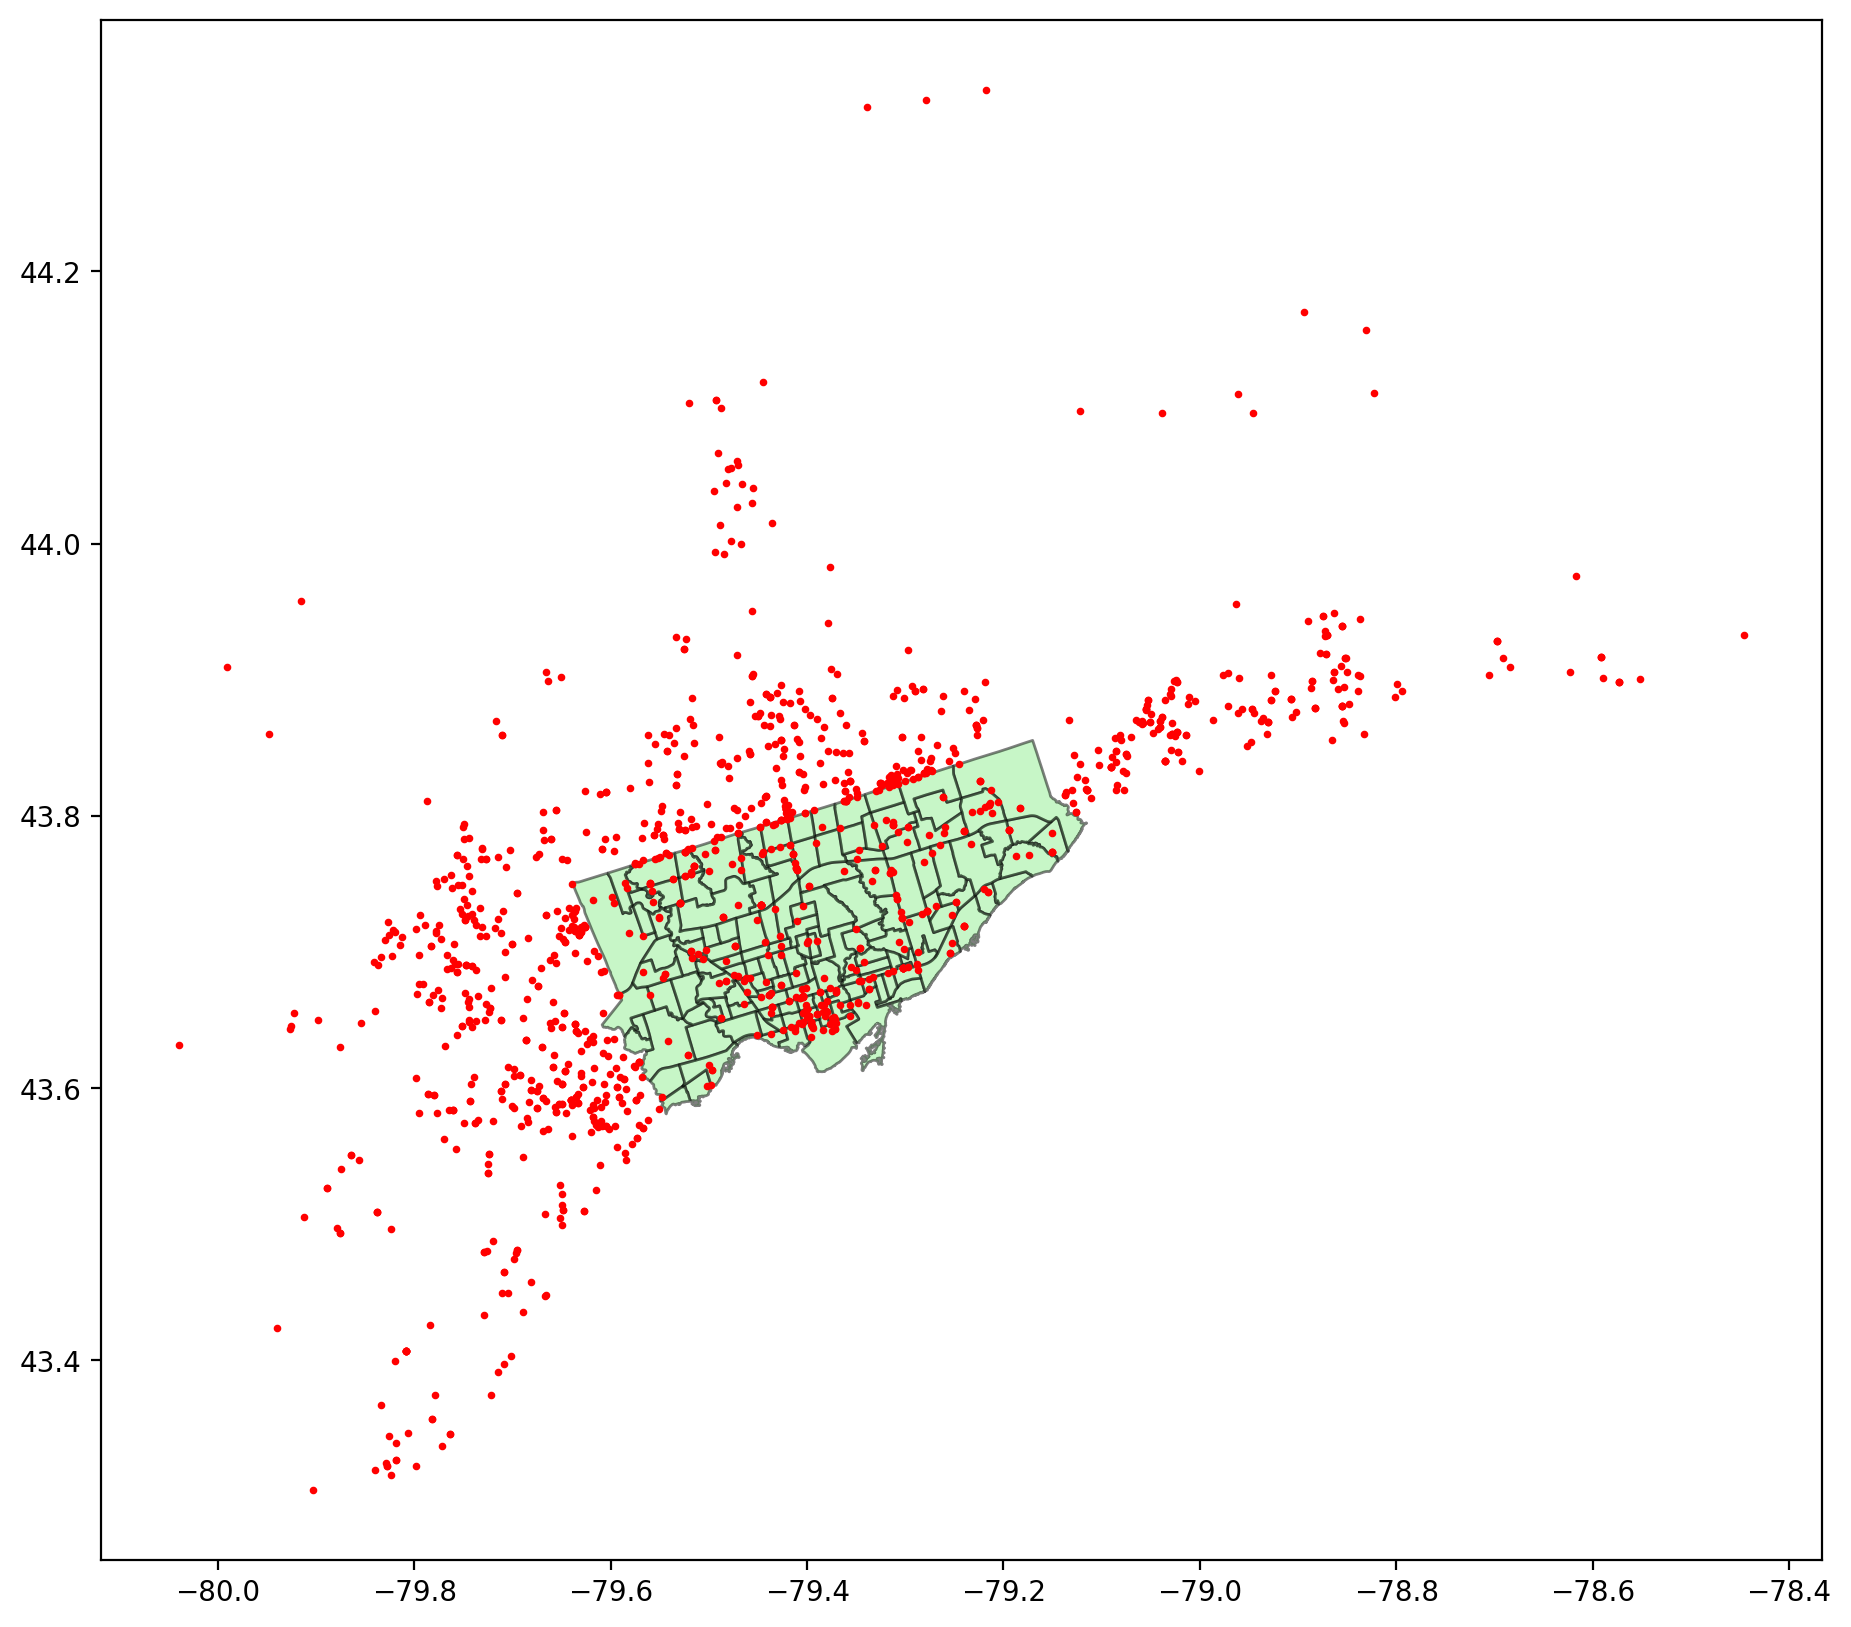

In [405]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [406]:
# get the points contained within the neighbourhoods
NSA_within_neighbourhood = gpd.sjoin(mci_point[mci_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

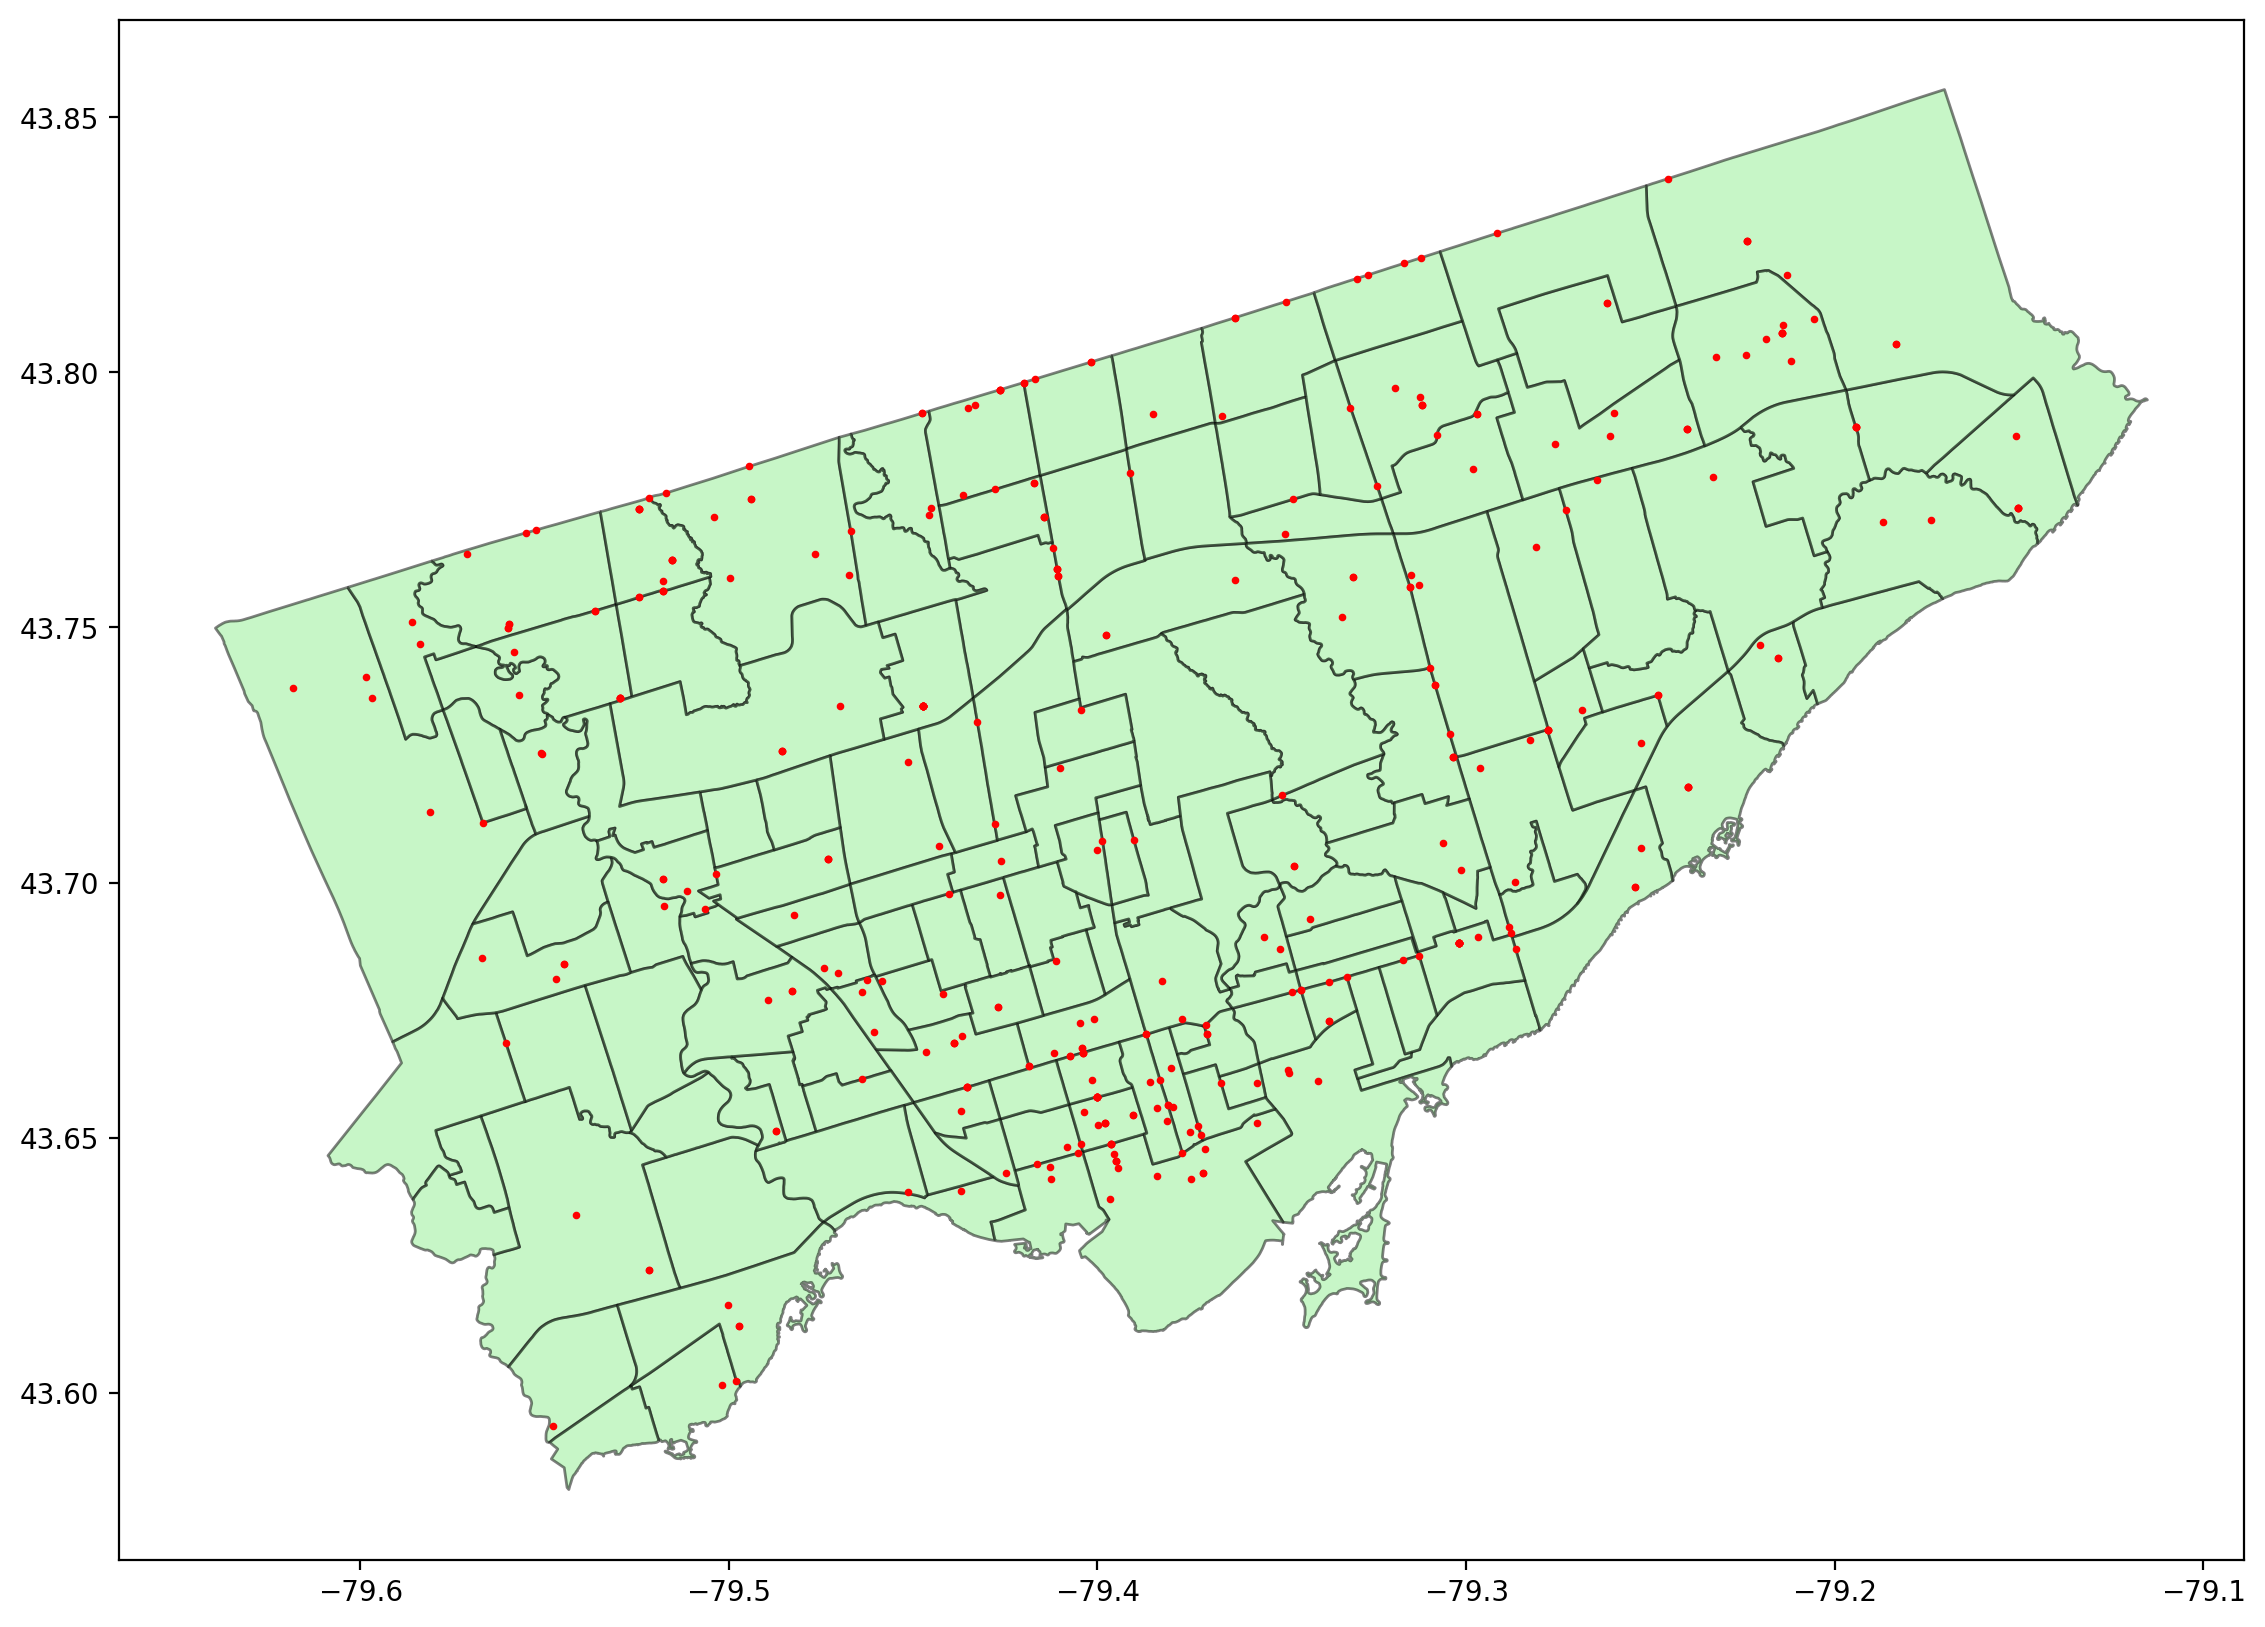

In [407]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

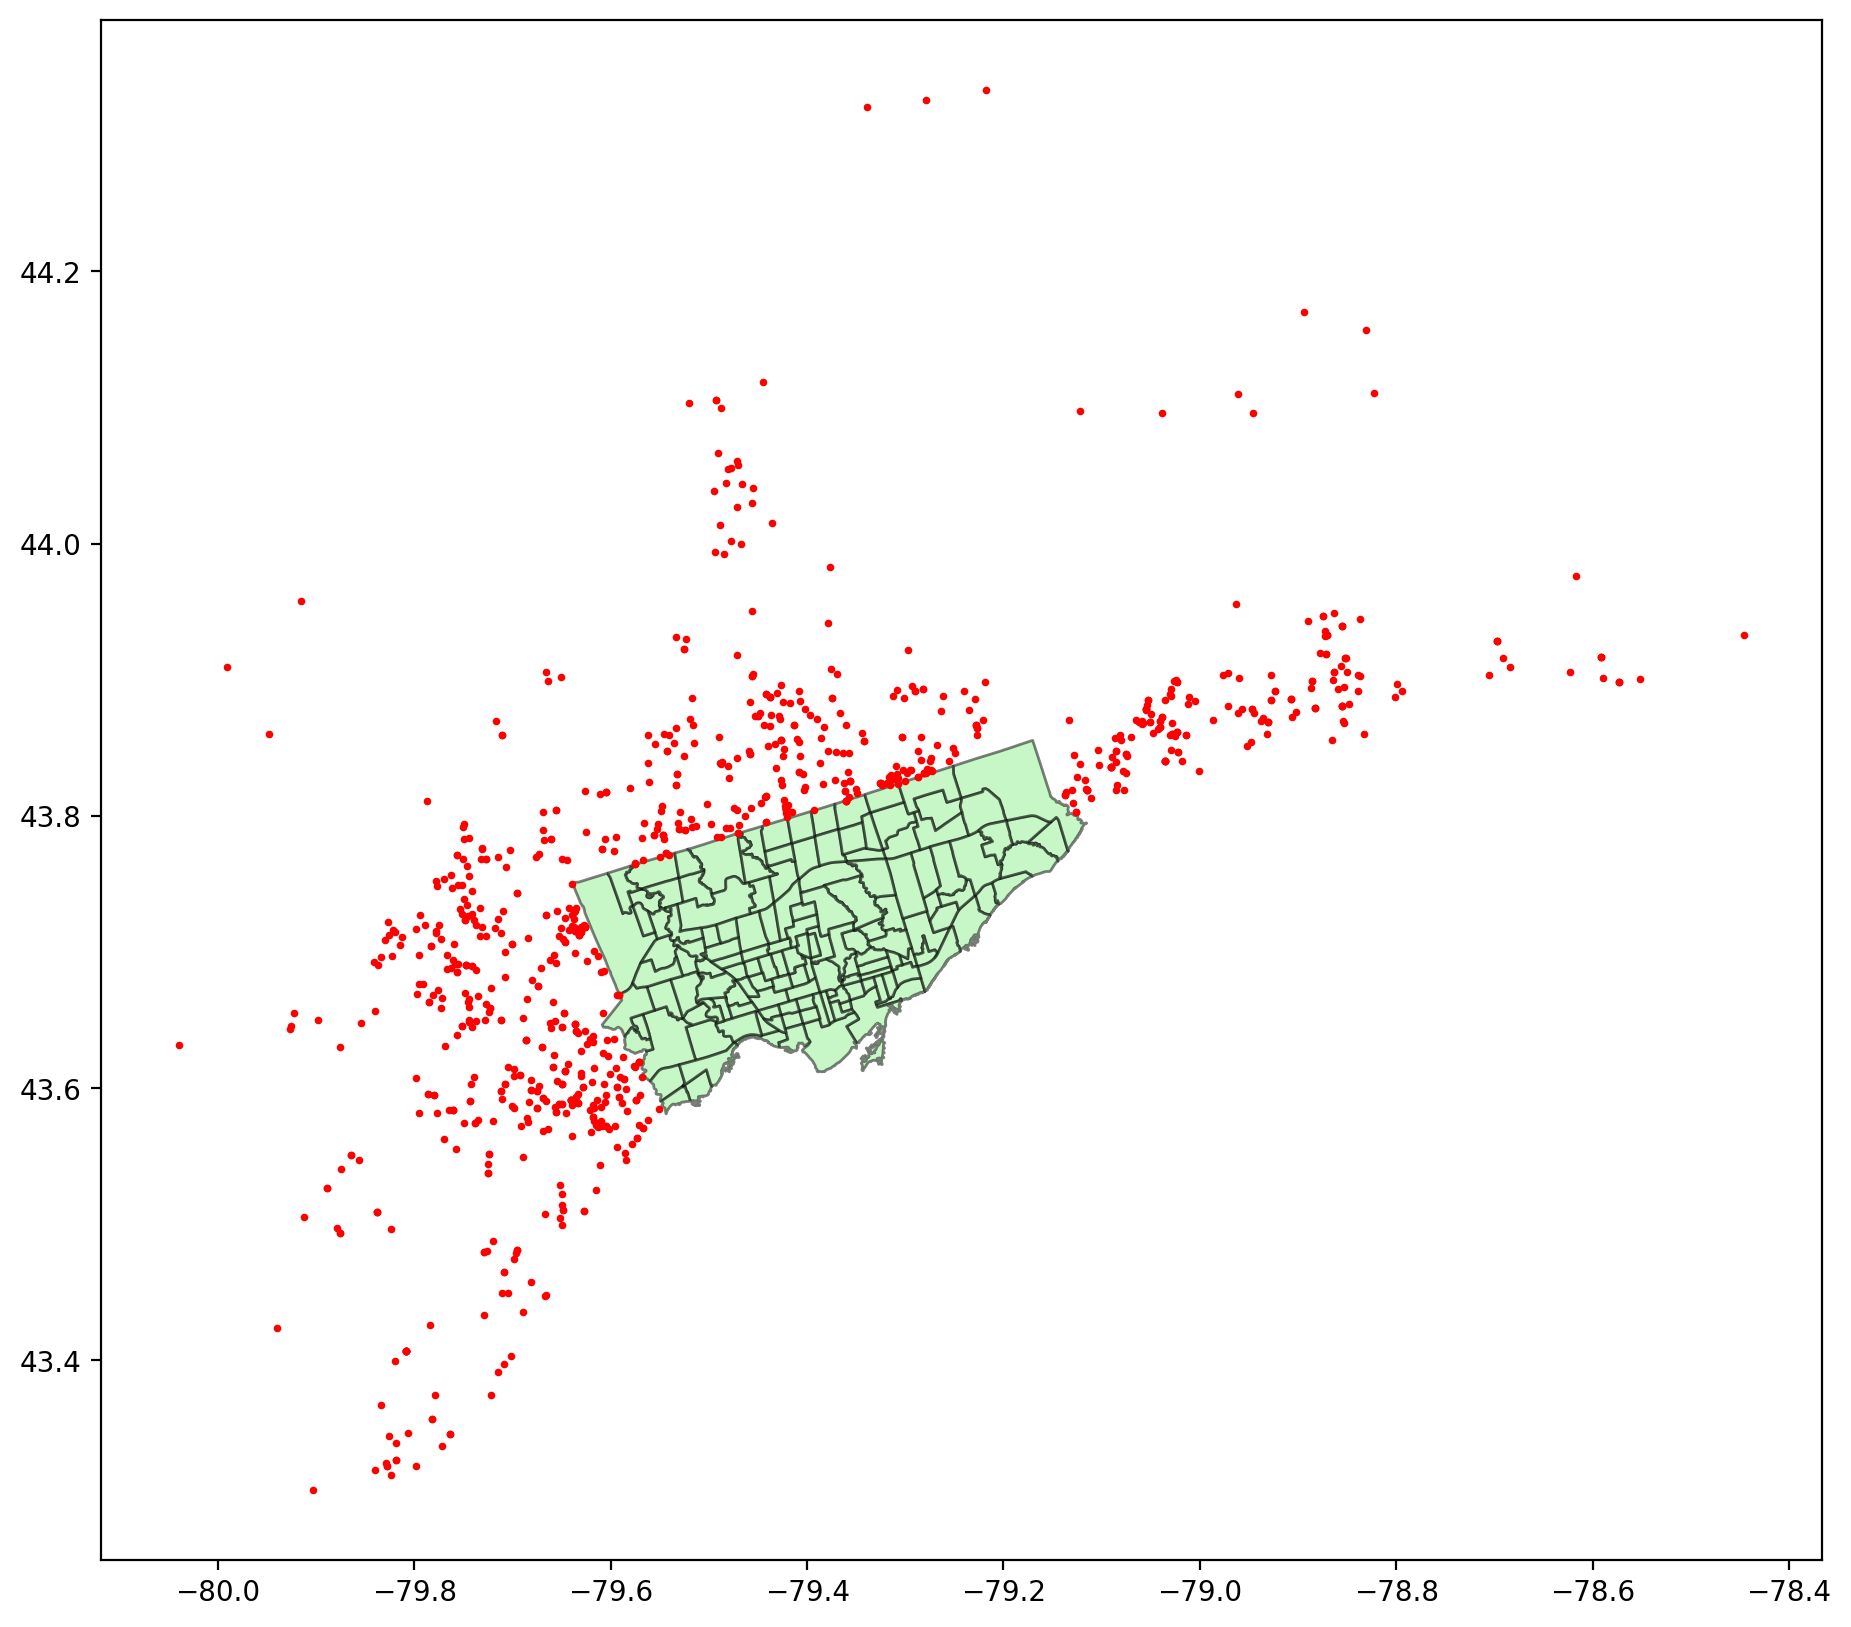

In [408]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
# no red dots should be inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

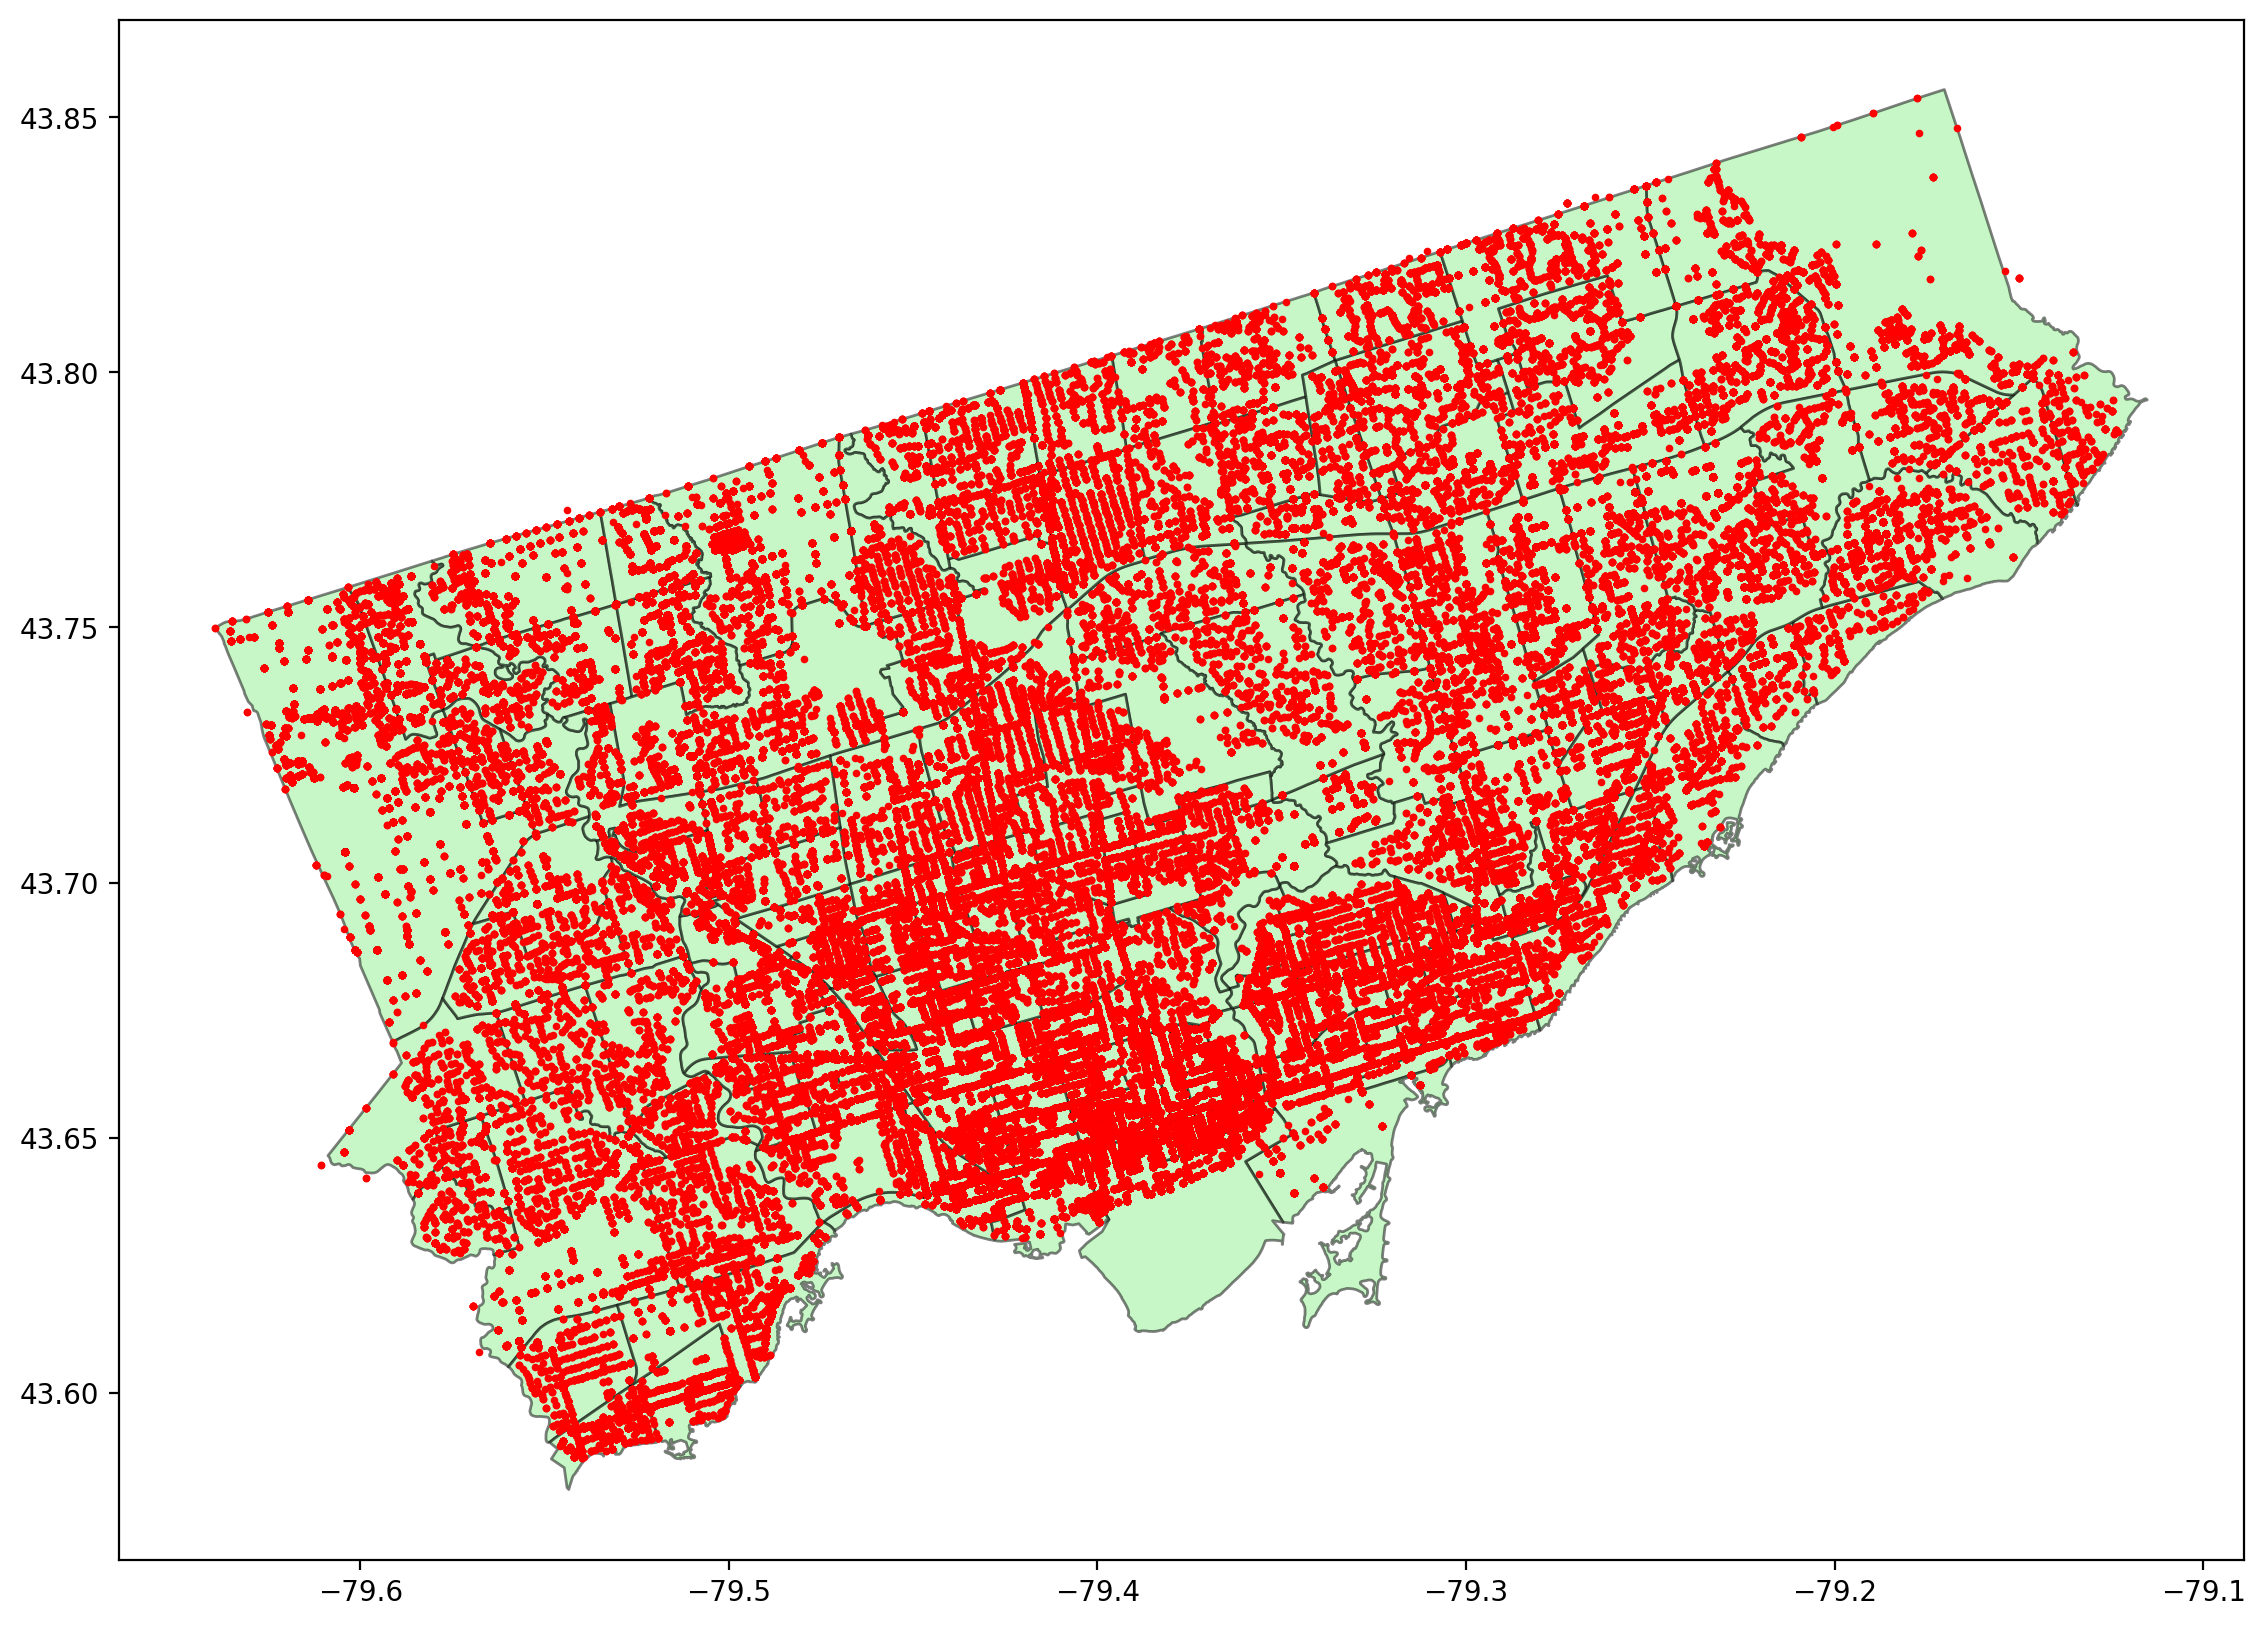

In [409]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Output

In [410]:
mci_point

occurrence_unique_id     occurrence_date  occurrence_year  \
0            GO-20141625305 2014-03-02 13:00:00             2014   
1            GO-20141272968 2013-12-24 13:00:00             2013   
2            GO-20141284361 2013-01-05 13:00:00             2013   
3            GO-20141292177 2013-12-31 13:00:00             2013   
4            GO-20141297201 2014-01-03 13:00:00             2014   
...                     ...                 ...              ...   
284868              1905589 2006-10-09 12:00:00             2006   
284869              1696286 2006-10-17 12:00:00             2006   
284870              1603174 2006-10-21 12:00:00             2006   
284871              1877732 2006-10-27 12:00:00             2006   
284872              1855834 2006-10-11 12:00:00             2006   

       occurrence_month  occurrence_day  occurrence_dayofyear  \
0                 March               2                    61   
1              December              24                   358   
2               January               5                     5   
3              December              31                   365   
4               January               3                     3   
...                 ...             ...                   ...   
284868          October               9                   282   
284869          October              17                   290   
284870          October              21                   294   
284871          October              27                   300   
284872          October              11                   284   

       occurrence_dayofweek              MCI hood_id  \
0                    Sunday          Assault       1   
1                   Tuesday          Robbery       1   
2                  Saturday          Assault       1   
3                   Tuesday  Break and Enter       1   
4                    Friday  Break and Enter       1   
...                     ...              ...     ...   
284868               Monday         Homicide      43   
284869              Tuesday         Homicide     119   
284870             Saturday         Homicide     135   
284871               Friday         Homicide      16   
284872            Wednesday         Homicide      71   

                          neighbourhood  longitude   latitude  \
0                West Humber-Clairville -79.590332  43.734013   
1                West Humber-Clairville -79.600701  43.731834   
2                West Humber-Clairville -79.600794  43.686423   
3                West Humber-Clairville -79.603876  43.743642   
4                West Humber-Clairville -79.586443  43.697108   
...                                 ...        ...        ...   
284868                 Victoria Village -79.304428  43.718907   
284869                 Wexford/Maryvale -79.300444  43.727942   
284870                      Morningside -79.194315  43.789276   
284871              Stonegate-Queensway -79.496230  43.627735   
284872  Cabbagetown-South St.James Town -79.364118  43.666093   

                          geometry  
0       POINT (-79.59033 43.73401)  
1       POINT (-79.60070 43.73183)  
2       POINT (-79.60079 43.68642)  
3       POINT (-79.60388 43.74364)  
4       POINT (-79.58644 43.69711)  
...                            ...  
284868  POINT (-79.30443 43.71891)  
284869  POINT (-79.30044 43.72794)  
284870  POINT (-79.19431 43.78928)  
284871  POINT (-79.49623 43.62774)  
284872  POINT (-79.36412 43.66609)  

[284873 rows x 13 columns]

<AxesSubplot:xlabel='occurrence_year'>

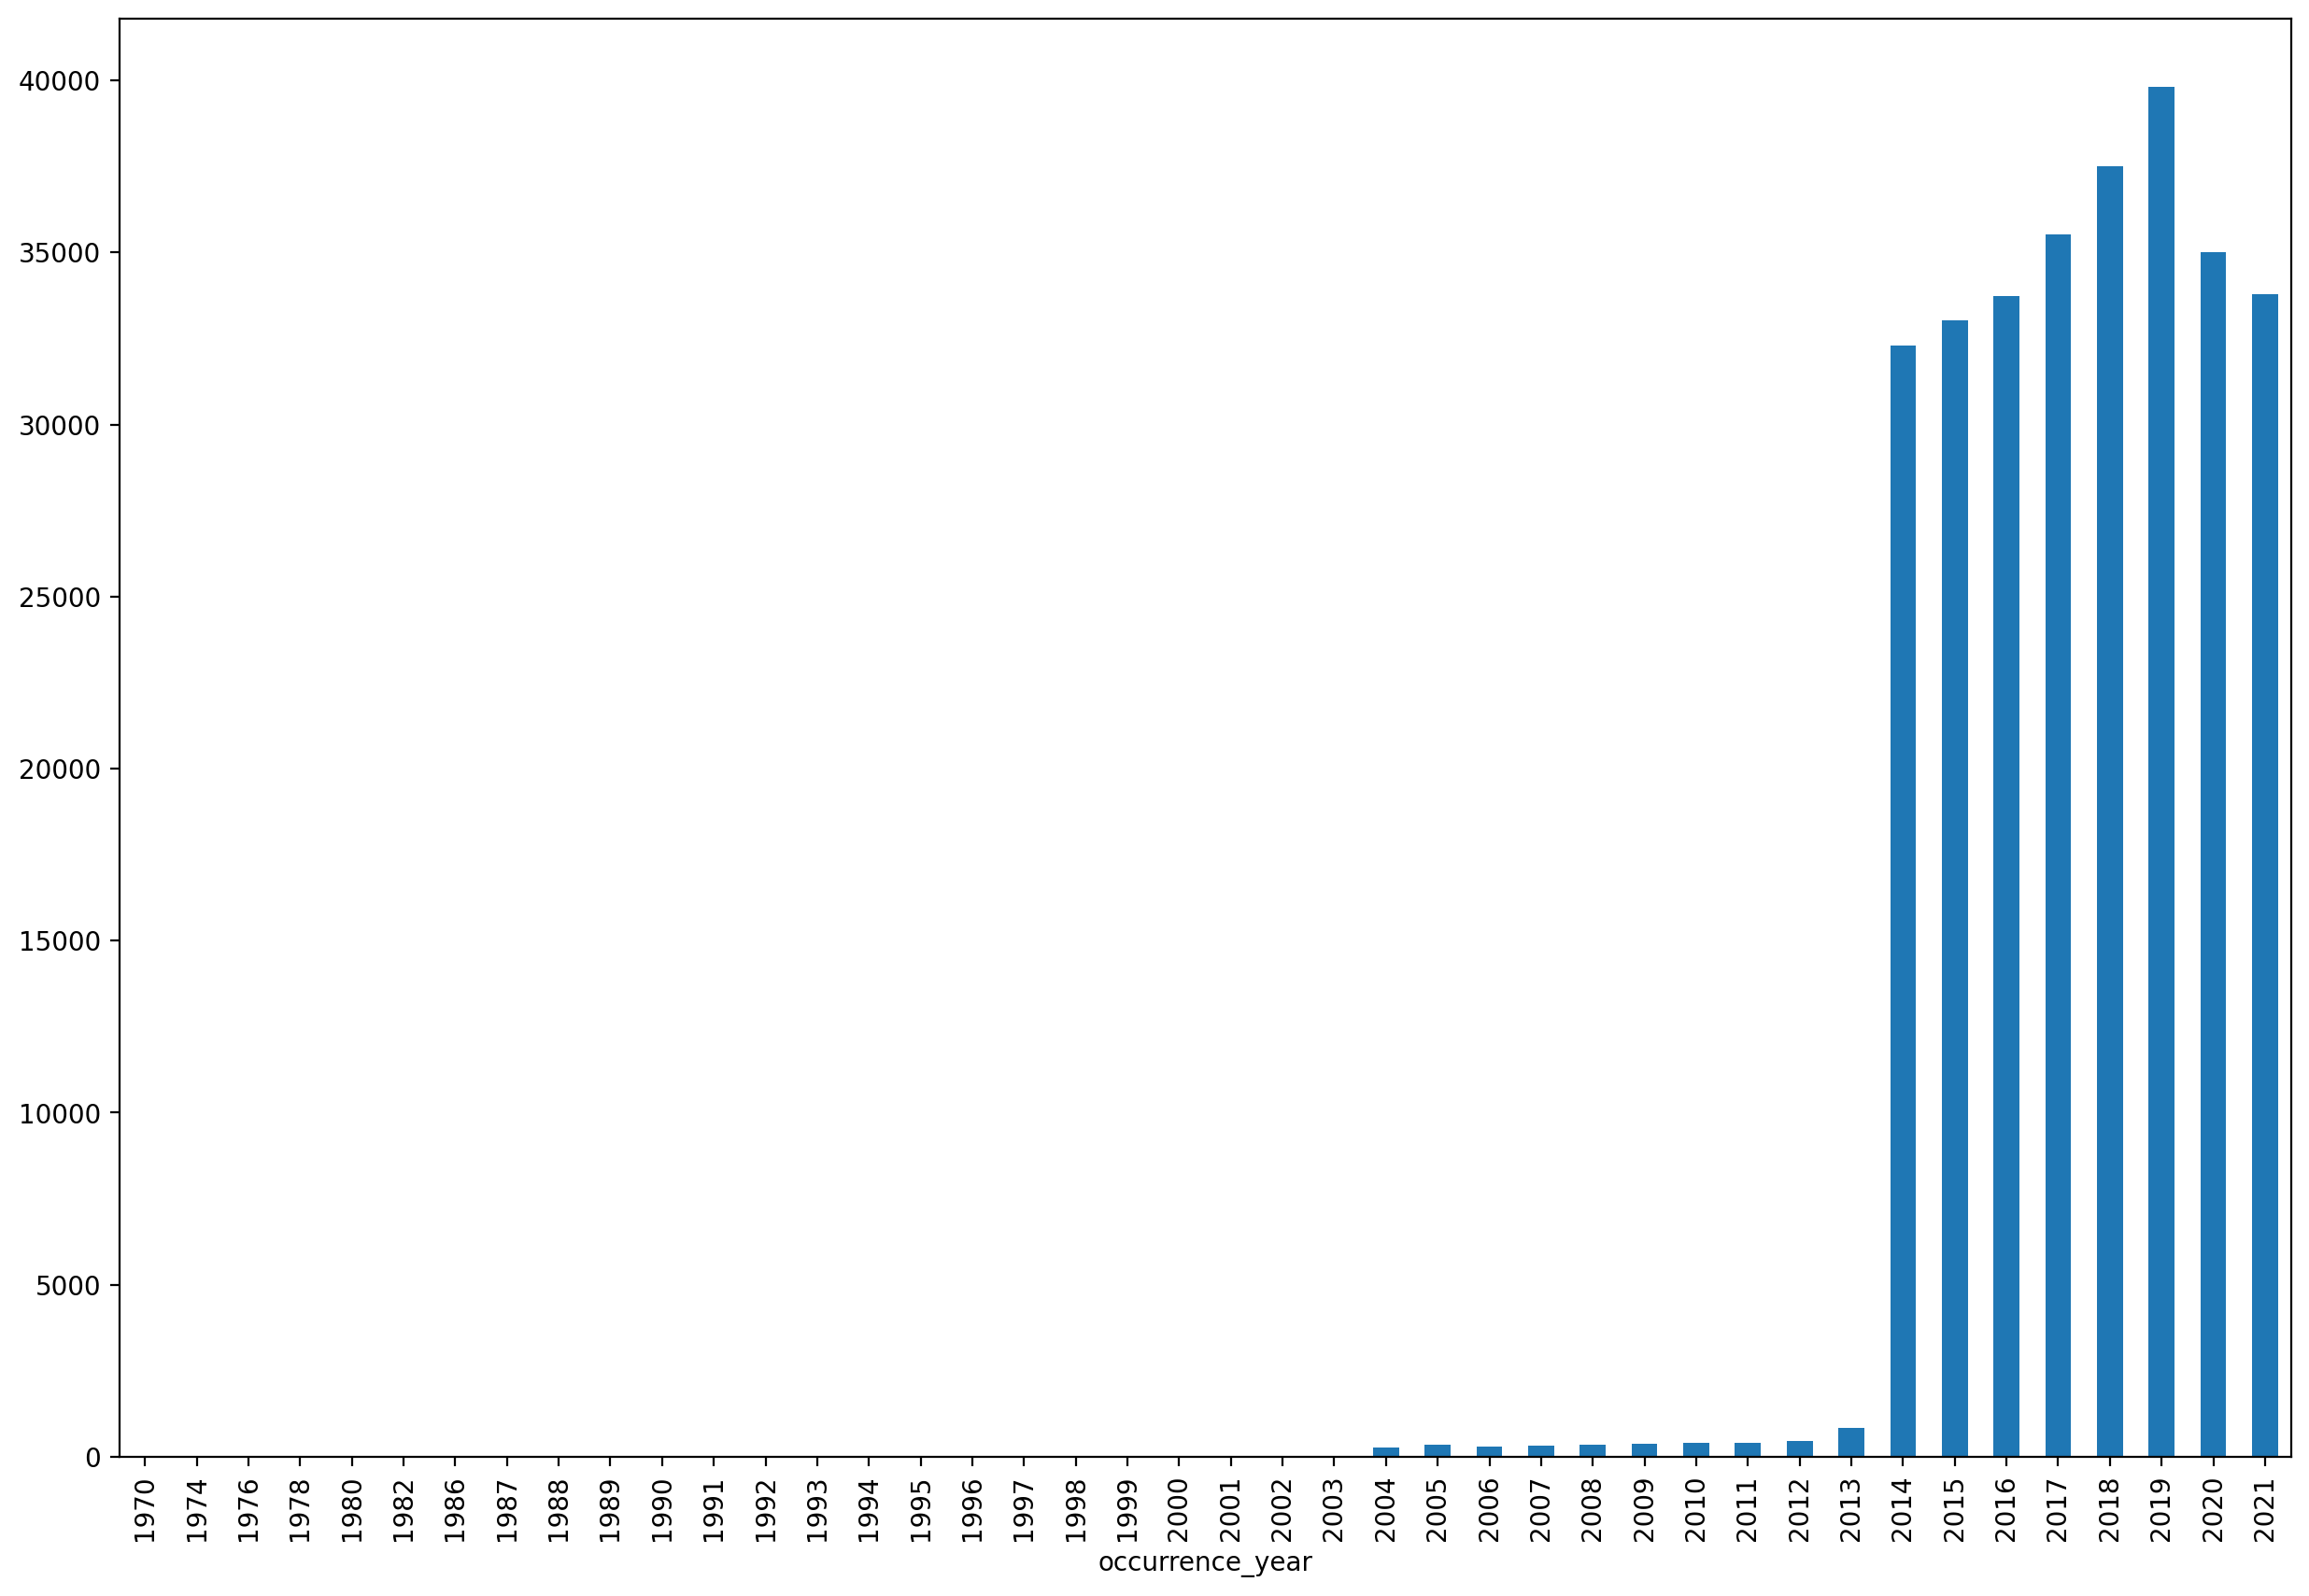

In [411]:
# There is limited data for crimes which happened before 2014
mci_point.groupby("occurrence_year").size().plot(kind="bar")

In [412]:
mci_select = mci_point[mci_point['occurrence_year'] >= 2014]

In [413]:
# output file to clean_data folder
# csv instead of geojson due to size
mci_select.to_csv('../data/processed/mci_select.csv', index=False)

# Aggregate crimes by neighbourhood after 2014

In [414]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
mci_groupby = mci_select[mci_select.neighbourhood != "NSA"].groupby(["neighbourhood", "hood_id", "occurrence_year", "MCI"]).size().reset_index(name="count")
mci_groupby

neighbourhood hood_id  occurrence_year              MCI  count
0        Agincourt North     129             2014          Assault     78
1        Agincourt North     129             2014       Auto Theft     19
2        Agincourt North     129             2014  Break and Enter     45
3        Agincourt North     129             2014          Robbery     34
4        Agincourt North     129             2014       Theft Over      1
...                  ...     ...              ...              ...    ...
6691  Yorkdale-Glen Park      31             2021  Break and Enter     66
6692  Yorkdale-Glen Park      31             2021         Homicide      1
6693  Yorkdale-Glen Park      31             2021          Robbery     17
6694  Yorkdale-Glen Park      31             2021        Shootings      9
6695  Yorkdale-Glen Park      31             2021       Theft Over     21

[6696 rows x 5 columns]

In [415]:
mci_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [416]:
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhood_years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [417]:
neighbourhoods_select = neighbourhoods[['neighbourhood', 'hood_id'] + 
                                       ['population' + x for x in neighbourhood_years] + 
                                       ['geometry']]

In [418]:
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhoods_select['population2021'] = (neighbourhoods_select['population2020'] * neighbourhoods_select['population2020'] / neighbourhoods_select['population2019']).values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [419]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_40180\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [420]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='population', 
                                        i=['neighbourhood', 'hood_id'], 
                                        j='occurrence_year').reset_index()
neighbourhoods_select

neighbourhood hood_id  occurrence_year      area  \
0                          Yonge-St.Clair      97             2014  1.161318   
1                          Yonge-St.Clair      97             2015  1.161318   
2                          Yonge-St.Clair      97             2016  1.161318   
3                          Yonge-St.Clair      97             2017  1.161318   
4                          Yonge-St.Clair      97             2018  1.161318   
...                                   ...     ...              ...       ...   
1115  Mimico (includes Humber Bay Shores)      17             2017  7.059185   
1116  Mimico (includes Humber Bay Shores)      17             2018  7.059185   
1117  Mimico (includes Humber Bay Shores)      17             2019  7.059185   
1118  Mimico (includes Humber Bay Shores)      17             2020  7.059185   
1119  Mimico (includes Humber Bay Shores)      17             2021  7.059185   

        population  
0     12597.000000  
1     12746.000000  
2     12950.000000  
3     13214.000000  
4     13508.000000  
...            ...  
1115  36043.000000  
1116  31671.000000  
1117  37839.000000  
1118  38738.000000  
1119  39658.358942  

[1120 rows x 5 columns]

In [421]:
mci_groupby

neighbourhood hood_id  occurrence_year              MCI  count
0        Agincourt North     129             2014          Assault     78
1        Agincourt North     129             2014       Auto Theft     19
2        Agincourt North     129             2014  Break and Enter     45
3        Agincourt North     129             2014          Robbery     34
4        Agincourt North     129             2014       Theft Over      1
...                  ...     ...              ...              ...    ...
6691  Yorkdale-Glen Park      31             2021  Break and Enter     66
6692  Yorkdale-Glen Park      31             2021         Homicide      1
6693  Yorkdale-Glen Park      31             2021          Robbery     17
6694  Yorkdale-Glen Park      31             2021        Shootings      9
6695  Yorkdale-Glen Park      31             2021       Theft Over     21

[6696 rows x 5 columns]

In [422]:
neighbourhood_crime_merge = neighbourhoods_select.merge(mci_groupby, how='outer', on=['neighbourhood', 'hood_id', 'occurrence_year'])
neighbourhood_crime_merge

neighbourhood hood_id  occurrence_year      area  \
0                          Yonge-St.Clair      97             2014  1.161318   
1                          Yonge-St.Clair      97             2014  1.161318   
2                          Yonge-St.Clair      97             2014  1.161318   
3                          Yonge-St.Clair      97             2014  1.161318   
4                          Yonge-St.Clair      97             2014  1.161318   
...                                   ...     ...              ...       ...   
6691  Mimico (includes Humber Bay Shores)      17             2021  7.059185   
6692  Mimico (includes Humber Bay Shores)      17             2021  7.059185   
6693  Mimico (includes Humber Bay Shores)      17             2021  7.059185   
6694  Mimico (includes Humber Bay Shores)      17             2021  7.059185   
6695  Mimico (includes Humber Bay Shores)      17             2021  7.059185   

        population              MCI  count  
0     12597.000000          Assault     18  
1     12597.000000       Auto Theft      2  
2     12597.000000  Break and Enter     37  
3     12597.000000          Robbery      4  
4     12597.000000       Theft Over      2  
...            ...              ...    ...  
6691  39658.358942       Auto Theft     55  
6692  39658.358942  Break and Enter     52  
6693  39658.358942          Robbery     13  
6694  39658.358942        Shootings      3  
6695  39658.358942       Theft Over     12  

[6696 rows x 7 columns]

In [423]:
neighbourhood_crime_merge.isna().sum()

neighbourhood      0
hood_id            0
occurrence_year    0
area               0
population         0
MCI                0
count              0
dtype: int64

In [424]:
neighbourhood_crime_merge.MCI.unique()

array(['Assault', 'Auto Theft', 'Break and Enter', 'Robbery',
       'Theft Over', 'Shootings', 'Homicide'], dtype=object)

In [425]:
mci_types = ['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']
neighbourhood_crime_all = neighbourhood_crime_merge[neighbourhood_crime_merge['MCI'].isin(mci_types)].groupby(['neighbourhood', 'hood_id', 'occurrence_year', 'area', 'population'])[['count']].sum().reset_index()
neighbourhood_crime_all["MCI"] = "MCI"

In [426]:
neighbourhood_crime_concat = pd.concat([neighbourhood_crime_merge, neighbourhood_crime_all], axis=0)
neighbourhood_crime_concat

neighbourhood hood_id  occurrence_year      area    population  \
0         Yonge-St.Clair      97             2014  1.161318  12597.000000   
1         Yonge-St.Clair      97             2014  1.161318  12597.000000   
2         Yonge-St.Clair      97             2014  1.161318  12597.000000   
3         Yonge-St.Clair      97             2014  1.161318  12597.000000   
4         Yonge-St.Clair      97             2014  1.161318  12597.000000   
...                  ...     ...              ...       ...           ...   
1115  Yorkdale-Glen Park      31             2017  6.038389  15797.000000   
1116  Yorkdale-Glen Park      31             2018  6.038389  18722.000000   
1117  Yorkdale-Glen Park      31             2019  6.038389  16970.000000   
1118  Yorkdale-Glen Park      31             2020  6.038389  17560.000000   
1119  Yorkdale-Glen Park      31             2021  6.038389  18170.512669   

                  MCI  count  
0             Assault     18  
1          Auto Theft      2  
2     Break and Enter     37  
3             Robbery      4  
4          Theft Over      2  
...               ...    ...  
1115              MCI    338  
1116              MCI    373  
1117              MCI    440  
1118              MCI    378  
1119              MCI    355  

[7816 rows x 7 columns]

In [427]:
# rate: number of crimes per 100k people
neighbourhood_crime_concat['rate'] = neighbourhood_crime_concat['count'] / neighbourhood_crime_concat['population'] * 10**5
# density: number of crimes per 1km^2
neighbourhood_crime_concat['density'] = neighbourhood_crime_concat['count'] / neighbourhood_crime_concat['area']

In [428]:
neighbourhood_crime_concat

neighbourhood hood_id  occurrence_year      area    population  \
0         Yonge-St.Clair      97             2014  1.161318  12597.000000   
1         Yonge-St.Clair      97             2014  1.161318  12597.000000   
2         Yonge-St.Clair      97             2014  1.161318  12597.000000   
3         Yonge-St.Clair      97             2014  1.161318  12597.000000   
4         Yonge-St.Clair      97             2014  1.161318  12597.000000   
...                  ...     ...              ...       ...           ...   
1115  Yorkdale-Glen Park      31             2017  6.038389  15797.000000   
1116  Yorkdale-Glen Park      31             2018  6.038389  18722.000000   
1117  Yorkdale-Glen Park      31             2019  6.038389  16970.000000   
1118  Yorkdale-Glen Park      31             2020  6.038389  17560.000000   
1119  Yorkdale-Glen Park      31             2021  6.038389  18170.512669   

                  MCI  count         rate    density  
0             Assault     18   142.891165  15.499636  
1          Auto Theft      2    15.876796   1.722182  
2     Break and Enter     37   293.720727  31.860363  
3             Robbery      4    31.753592   3.444364  
4          Theft Over      2    15.876796   1.722182  
...               ...    ...          ...        ...  
1115              MCI    338  2139.646768  55.975198  
1116              MCI    373  1992.308514  61.771447  
1117              MCI    440  2592.810843  72.867122  
1118              MCI    378  2152.619590  62.599482  
1119              MCI    355  1953.714826  58.790519  

[7816 rows x 9 columns]

In [433]:
neighbourhood_crime_melt = neighbourhood_crime_concat.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'area', 'population', 'MCI'],
                                                           value_vars=['count', 'rate', 'density'],
                                                           var_name='type',
                                                           value_name='value')
neighbourhood_crime_melt['MCI_Typeyear'] = neighbourhood_crime_melt['MCI'].astype(str).apply(lambda x: x.replace(' ', '')) + "_" + neighbourhood_crime_melt['type'] + neighbourhood_crime_melt['occurrence_year'].astype(str)
neighbourhood_crime_melt

neighbourhood hood_id  occurrence_year      area    population  \
0          Yonge-St.Clair      97             2014  1.161318  12597.000000   
1          Yonge-St.Clair      97             2014  1.161318  12597.000000   
2          Yonge-St.Clair      97             2014  1.161318  12597.000000   
3          Yonge-St.Clair      97             2014  1.161318  12597.000000   
4          Yonge-St.Clair      97             2014  1.161318  12597.000000   
...                   ...     ...              ...       ...           ...   
23443  Yorkdale-Glen Park      31             2017  6.038389  15797.000000   
23444  Yorkdale-Glen Park      31             2018  6.038389  18722.000000   
23445  Yorkdale-Glen Park      31             2019  6.038389  16970.000000   
23446  Yorkdale-Glen Park      31             2020  6.038389  17560.000000   
23447  Yorkdale-Glen Park      31             2021  6.038389  18170.512669   

                   MCI     type      value             MCI_Typeyear  
0              Assault    count  18.000000        Assault_count2014  
1           Auto Theft    count   2.000000      AutoTheft_count2014  
2      Break and Enter    count  37.000000  BreakandEnter_count2014  
3              Robbery    count   4.000000        Robbery_count2014  
4           Theft Over    count   2.000000      TheftOver_count2014  
...                ...      ...        ...                      ...  
23443              MCI  density  55.975198          MCI_density2017  
23444              MCI  density  61.771447          MCI_density2018  
23445              MCI  density  72.867122          MCI_density2019  
23446              MCI  density  62.599482          MCI_density2020  
23447              MCI  density  58.790519          MCI_density2021  

[23448 rows x 9 columns]

In [434]:
neighbourhood_crime_pivot = neighbourhood_crime_melt.pivot(index=['neighbourhood', 'hood_id'], columns=['MCI_Typeyear'], values=['value'])
neighbourhood_crime_pivot

value                    \
MCI_Typeyear                         Assault_count2014 Assault_count2015   
neighbourhood                hood_id                                       
Agincourt North              129                  78.0              69.0   
Agincourt South-Malvern West 128                 106.0              98.0   
Alderwood                    20                   47.0              46.0   
Annex                        95                  243.0             264.0   
Banbury-Don Mills            42                   61.0              74.0   
...                                                ...               ...   
Wychwood                     94                   54.0              74.0   
Yonge-Eglinton               100                  58.0              67.0   
Yonge-St.Clair               97                   18.0              24.0   
York University Heights      27                  271.0             294.0   
Yorkdale-Glen Park           31                  105.0             133.0   

                                                                          \
MCI_Typeyear                         Assault_count2016 Assault_count2017   
neighbourhood                hood_id                                       
Agincourt North              129                  78.0              73.0   
Agincourt South-Malvern West 128                 143.0             109.0   
Alderwood                    20                   39.0              24.0   
Annex                        95                  282.0             275.0   
Banbury-Don Mills            42                   88.0             112.0   
...                                                ...               ...   
Wychwood                     94                   79.0              54.0   
Yonge-Eglinton               100                  63.0              68.0   
Yonge-St.Clair               97                   35.0              25.0   
York University Heights      27                  363.0             359.0   
Yorkdale-Glen Park           31                  179.0             164.0   

                                                                          \
MCI_Typeyear                         Assault_count2018 Assault_count2019   
neighbourhood                hood_id                                       
Agincourt North              129                  81.0              80.0   
Agincourt South-Malvern West 128                 113.0             114.0   
Alderwood                    20                   27.0              36.0   
Annex                        95                  272.0             322.0   
Banbury-Don Mills            42                   76.0              74.0   
...                                                ...               ...   
Wychwood                     94                   76.0              67.0   
Yonge-Eglinton               100                  67.0              92.0   
Yonge-St.Clair               97                   33.0              33.0   
York University Heights      27                  370.0             372.0   
Yorkdale-Glen Park           31                  174.0             213.0   

                                                                          \
MCI_Typeyear                         Assault_count2020 Assault_count2021   
neighbourhood                hood_id                                       
Agincourt North              129                  65.0              60.0   
Agincourt South-Malvern West 128                 127.0             150.0   
Alderwood                    20                   34.0              27.0   
Annex                        95                  284.0             305.0   
Banbury-Don Mills            42                   83.0              82.0   
...                                                ...               ...   
Wychwood                     94                   86.0              57.0   
Yonge-Eglinton               100                  93.0              61.0   
Yonge-St.Clair    

In [435]:
neighbourhood_crime_pivot.columns = neighbourhood_crime_pivot.columns.droplevel(0)

In [436]:
neighbourhood_crime_pivot = neighbourhood_crime_pivot.reset_index()

In [437]:
neighbourhood_crime_pivot

MCI_Typeyear                 neighbourhood hood_id  Assault_count2014  \
0                          Agincourt North     129               78.0   
1             Agincourt South-Malvern West     128              106.0   
2                                Alderwood      20               47.0   
3                                    Annex      95              243.0   
4                        Banbury-Don Mills      42               61.0   
..                                     ...     ...                ...   
135                               Wychwood      94               54.0   
136                         Yonge-Eglinton     100               58.0   
137                         Yonge-St.Clair      97               18.0   
138                York University Heights      27              271.0   
139                     Yorkdale-Glen Park      31              105.0   

MCI_Typeyear  Assault_count2015  Assault_count2016  Assault_count2017  \
0                          69.0               78.0               73.0   
1                          98.0              143.0              109.0   
2                          46.0               39.0               24.0   
3                         264.0              282.0              275.0   
4                          74.0               88.0              112.0   
..                          ...                ...                ...   
135                        74.0               79.0               54.0   
136                        67.0               63.0               68.0   
137                        24.0               35.0               25.0   
138                       294.0              363.0              359.0   
139                       133.0              179.0              164.0   

MCI_Typeyear  Assault_count2018  Assault_count2019  Assault_count2020  \
0                          81.0               80.0               65.0   
1                         113.0              114.0              127.0   
2                          27.0               36.0               34.0   
3                         272.0              322.0              284.0   
4                          76.0               74.0               83.0   
..                          ...                ...                ...   
135                        76.0               67.0               86.0   
136                        67.0               92.0               93.0   
137                        33.0               33.0               25.0   
138                       370.0              372.0              346.0   
139                       174.0              213.0              155.0   

MCI_Typeyear  Assault_count2021  Assault_density2014  Assault_density2015  \
0                          60.0            10.741104             9.501746   
1                         150.0            13.463475            12.447364   
2                          27.0             9.440516             9.239654   
3                         305.0            87.084986            94.610849   
4                          82.0             6.074863             7.369505   
..                          ...                  ...                  ...   
135                        57.0            32.101250            43.990602   
136                        61.0            35.142298            40.595413   
137                        48.0            15.499636            20.666181   
138                       327.0            20.457863            22.194140   
139                       159.0            17.388745            22.025744   

MCI_Typeyear  Assault_density2016  Assault_density2017  Assault_density2018  \
0                       10.741104            10.052572            11.154224   
1                       18.162990            13.844517            14.352573   
2                        7.833619             4.820689             5.423275   
3                      101.061589            98.552968            97.477844   
4                        8.763736            11.1

In [438]:
# Missing data: number of neighbourhoods which have no data for a particular MCI type in a particular year
# same number of missing data for each type of MCI
pd.DataFrame(neighbourhood_crime_pivot.isna().sum()[neighbourhood_crime_pivot.isna().sum() != 0]).T

MCI_Typeyear  AutoTheft_count2015  AutoTheft_count2017  AutoTheft_density2015  \
0                               1                    1                      1   

MCI_Typeyear  AutoTheft_density2017  AutoTheft_rate2015  AutoTheft_rate2017  \
0                                 1                   1                   1   

MCI_Typeyear  Homicide_count2014  Homicide_count2015  Homicide_count2016  \
0                             98                 101                  96   

MCI_Typeyear  Homicide_count2017  Homicide_count2018  Homicide_count2019  \
0                            101                  85                  87   

MCI_Typeyear  Homicide_count2020  Homicide_count2021  Homicide_density2014  \
0                             92                  88                    98   

MCI_Typeyear  Homicide_density2015  Homicide_density2016  \
0                              101                    96   

MCI_Typeyear  Homicide_density2017  Homicide_density2018  \
0                              101                    85   

MCI_Typeyear  Homicide_density2019  Homicide_density2020  \
0                               87                    92   

MCI_Typeyear  Homicide_density2021  Homicide_rate2014  Homicide_rate2015  \
0                               88                 98                101   

MCI_Typeyear  Homicide_rate2016  Homicide_rate2017  Homicide_rate2018  \
0                            96                101                 85   

MCI_Typeyear  Homicide_rate2019  Homicide_rate2020  Homicide_rate2021  \
0                            87                 92                 88   

MCI_Typeyear  Robbery_count2014  Robbery_count2016  Robbery_count2018  \
0                             1                  1                  1   

MCI_Typeyear  Robbery_count2021  Robbery_density2014  Robbery_density2016  \
0                             2                    1                    1   

MCI_Typeyear  Robbery_density2018  Robbery_density2021  Robbery_rate2014  \
0                               1                    2                 1   

MCI_Typeyear  Robbery_rate2016  Robbery_rate2018  Robbery_rate2021  \
0                            1                 1                 2   

MCI_Typeyear  Shootings_count2014  Shootings_count2015  Shootings_count2016  \
0                              65                   61                   42   

MCI_Typeyear  Shootings_count2017  Shootings_count2018  Shootings_count2019  \
0                              43                   39                   26   

MCI_Typeyear  Shootings_count2020  Shootings_count2021  Shootings_density2014  \
0                              40                   36                     65   

MCI_Typeyear  Shootings_density2015  Shootings_density2016  \
0                                61                     42   

MCI_Typeyear  Shootings_density2017  Shootings_density2018  \
0                                43                     39   

MCI_Typeyear  Shootings_density2019  Shootings_density2020  \
0                                26                     40   

MCI_Typeyear  Shootings_density2021  Shootings_rate2014  Shootings_rate2015  \
0                                36                  65                  61   

MCI_Typeyear  Shootings_rate2016  Shootings_rate2017  Shootings_rate2018  \
0                             42                  43                  39   

MCI_Typeyear  Shootings_rate2019  Shootings_rate2020  Shootings_rate2021  \
0                             26                  40                  36   

MCI_Typeyear  TheftOver_count2014  TheftOver_count2015  TheftOver_count2016  \
0                               6                    2                    8   

MCI_Typeyear  TheftOver_count2017  TheftOver_count2018  TheftOver_count2019  \
0                               3                    2                    2   

MCI_Typeyear  TheftOver_count2020  TheftOver_count2021  TheftOver_density2014  \
0                               3                   11                      6   

MCI_Typ

In [439]:
neighbourhood_crime = neighbourhoods[['neighbourhood', 'hood_id', 'district', 'distance_km', 'geometry']].merge(neighbourhood_crime_pivot.fillna(0), how='outer', on=['neighbourhood', 'hood_id'])
neighbourhood_crime

neighbourhood hood_id district  distance_km  \
0                         Yonge-St.Clair      97      C02     2.791462   
1                York University Heights      27      W05    13.676191   
2                       Lansing-Westgate      38      C07    10.427749   
3                     Yorkdale-Glen Park      31      W04     7.592207   
4                    Stonegate-Queensway      16      W07     9.017845   
..                                   ...     ...      ...          ...   
135                        Pleasant View      46      C15    14.643244   
136                             Wychwood      94      C02     2.864021   
137                   Leaside-Bennington      56      C11     5.149543   
138                 Briar Hill-Belgravia     108      W04     6.111904   
139  Mimico (includes Humber Bay Shores)      17      W06     9.894878   

                                              geometry  Assault_count2014  \
0    POLYGON ((-79.39115 43.68108, -79.39137 43.680...               18.0   
1    POLYGON ((-79.50525 43.75987, -79.50484 43.759...              271.0   
2    POLYGON ((-79.43994 43.76156, -79.44000 43.761...               41.0   
3    POLYGON ((-79.43965 43.70561, -79.44007 43.705...              105.0   
4    POLYGON ((-79.49258 43.64744, -79.49273 43.647...               90.0   
..                                                 ...                ...   
135  POLYGON ((-79.34341 43.79517, -79.34355 43.795...               32.0   
136  POLYGON ((-79.43588 43.68015, -79.43488 43.680...               54.0   
137  POLYGON ((-79.37745 43.71309, -79.37758 43.713...               39.0   
138  POLYGON ((-79.46458 43.69216, -79.46469 43.692...               80.0   
139  POLYGON ((-79.48036 43.62107, -79.48029 43.621...              206.0   

     Assault_count2015  Assault_count2016  Assault_count2017  \
0                 24.0               35.0               25.0   
1                294.0              363.0              359.0   
2                 81.0               69.0               92.0   
3                133.0              179.0              164.0   
4                 72.0               78.0               99.0   
..                 ...                ...                ...   
135               46.0               54.0               55.0   
136               74.0               79.0               54.0   
137               41.0               30.0               36.0   
138               89.0               80.0               82.0   
139              207.0              242.0              346.0   

     Assault_count2018  Assault_count2019  Assault_count2020  \
0                 33.0               33.0               25.0   
1                370.0              372.0              346.0   
2                 70.0               71.0              100.0   
3                174.0              213.0              155.0   
4                 88.0               83.0              104.0   
..                 ...                ...                ...   
135               47.0               49.0               43.0   
136               76.0               67.0               86.0   
137               36.0               32.0               31.0   
138               87.0               81.0               81.0   
139              487.0              331.0              281.0   

     Assault_count2021  Assault_density2014  Assault_density2015  \
0                 48.0            15.499636            20.666181   
1                327.0            20.457863            22.194140   
2                 90.0             7.669074            15.151098   
3                159.0            17.388745            22.025744   
4                 72.0            11.325777             9.060622   
..                 ...                  ...                  ...   
135               23.0            10.783496            15.501275   
136               57.0            32.101250            43.990602   
137               49.0             8.150998             8.56899

In [440]:
neighbourhood_crime.to_file('../data/processed/neighbourhoods_crime.geojson', driver='GeoJSON')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
